In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import pydicom
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.applications import VGG16, ResNet50V2, DenseNet121, InceptionV3, EfficientNetB3, VGG19, InceptionResNetV2
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
import random
import tensorflow as tf

print('complete')

def preprocess_image(dcm_file, target_size=(128, 128)):
    dcm_data = pydicom.read_file(dcm_file)
    img = dcm_data.pixel_array.astype(np.uint8)
    img = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)
    img = np.stack((img,) * 3, axis=-1)
    return img



def read_train_data(train_labels, target_size=(128, 128)):
    train_images = []
    for _, row in tqdm(train_labels.iterrows(), total=len(train_labels), desc="Loading Data"):
        patient_id = row["patientId"]
        dcm_file = os.path.join(train_path, f"{patient_id}.dcm")
        image = preprocess_image(dcm_file, target_size=target_size)
        train_images.append(image)
    return np.array(train_images)


train_class = pd.read_csv('../input/rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv')
train_labels = pd.read_csv('../input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')
train_meta = pd.concat([train_labels, train_class.drop(columns=['patientId'])], axis=1)
train_path = Path('../input/rsna-pneumonia-detection-challenge/stage_2_train_images')
train_images = read_train_data(train_labels)


datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.1,
    fill_mode='nearest'
)


y = pd.get_dummies(train_labels["Target"]).values
random_state = 42
x_train, X_test, Y_train, y_test = train_test_split(train_images, y, test_size=0.2, random_state=random_state)
X_train, X_valid, y_train, y_valid = train_test_split(x_train, Y_train, test_size=0.2, random_state=random_state)


ADJUSTED_IMAGE_SIZE = 128
input_shape = (ADJUSTED_IMAGE_SIZE, ADJUSTED_IMAGE_SIZE, 3)
num_classes = y_train.shape[1]



batch_size = 16
epochs = 50
steps_per_epoch = len(X_train) // batch_size

callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
]


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


complete


Loading Data: 100%|██████████| 30227/30227 [05:09<00:00, 97.59it/s] 


In [2]:
print(num_classes)

2


In [3]:
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False


augment = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.15, dtype='float32')
], name='AugmentationLayer')

input_shape = (128, 128, 3)  
inputs = Input(shape=input_shape, name='inputLayer')
x = augment(inputs)
pretrain_out = base_model(x, training=False)
x = Flatten()(pretrain_out)
x = Dense(64, activation='relu')(x)
x = Dense(num_classes, name='outputLayer')(x)
outputs = Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x)
model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=AdamW(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

94668760/94668760 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 128, 128, 3)]     0         
                                                                 
 AugmentationLayer (Sequenti  (None, 128, 128, 3)      0         
 al)                                                             
                                                                 
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 64)                2097216   
                                                                 
 outputLayer (Dense)         (None, 2)                 130    

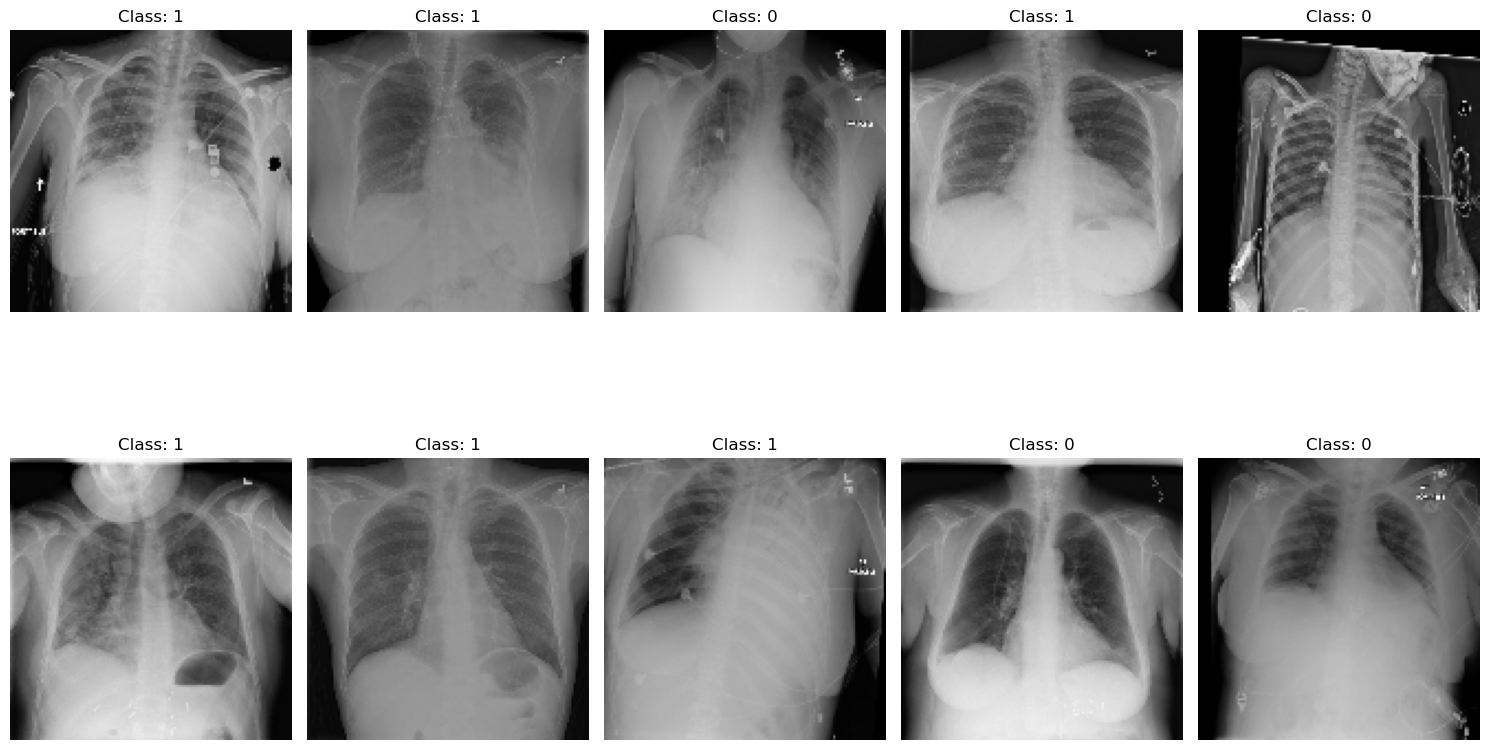

In [15]:
sample_indices = random.sample(range(len(X_test)), 10)  

plt.figure(figsize=(15, 10)) 
for i, idx in enumerate(sample_indices):
    plt.subplot(2, 5, i + 1)  
    plt.imshow(X_test[idx])
    class_label = np.argmax(y_test[idx])  
    plt.title(f"Class: {class_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


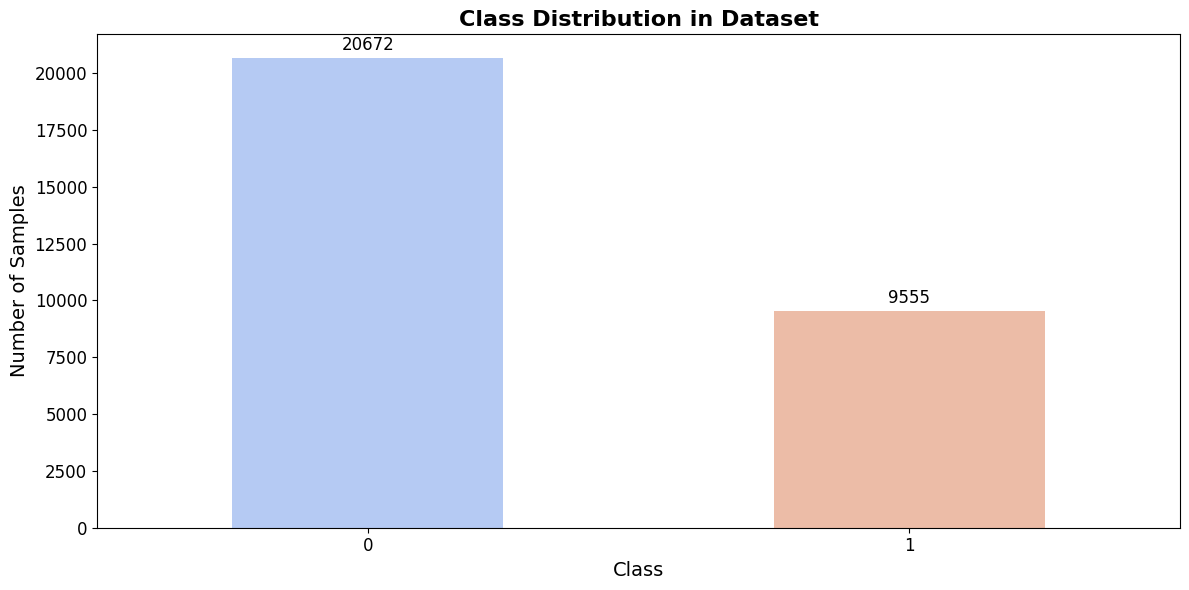

Class 0: 68.39%
Class 1: 31.61%
30227


In [6]:

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def class_balance(y_train):
    if len(y_train.shape) > 1 and y_train.shape[1] > 1:
        y_train = np.argmax(y_train, axis=1)
    class_counts = np.bincount(y_train)
    classes = np.unique(y_train)
    class_balance = dict(zip(classes, class_counts))
    
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=list(class_balance.keys()), y=list(class_balance.values()), palette="coolwarm", width=0.5)
    plt.title('Class Distribution in Dataset', fontsize=16, fontweight='bold')
    plt.xlabel('Class', fontsize=14)
    plt.ylabel('Number of Samples', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points',
                    fontsize=12)
    
    plt.tight_layout()
    plt.show()

    total_samples = len(y_train)
    for cls, count in class_balance.items():
        percentage = (count / total_samples) * 100
        print(f"Class {cls}: {percentage:.2f}%")

class_balance(y)
print(len(y))


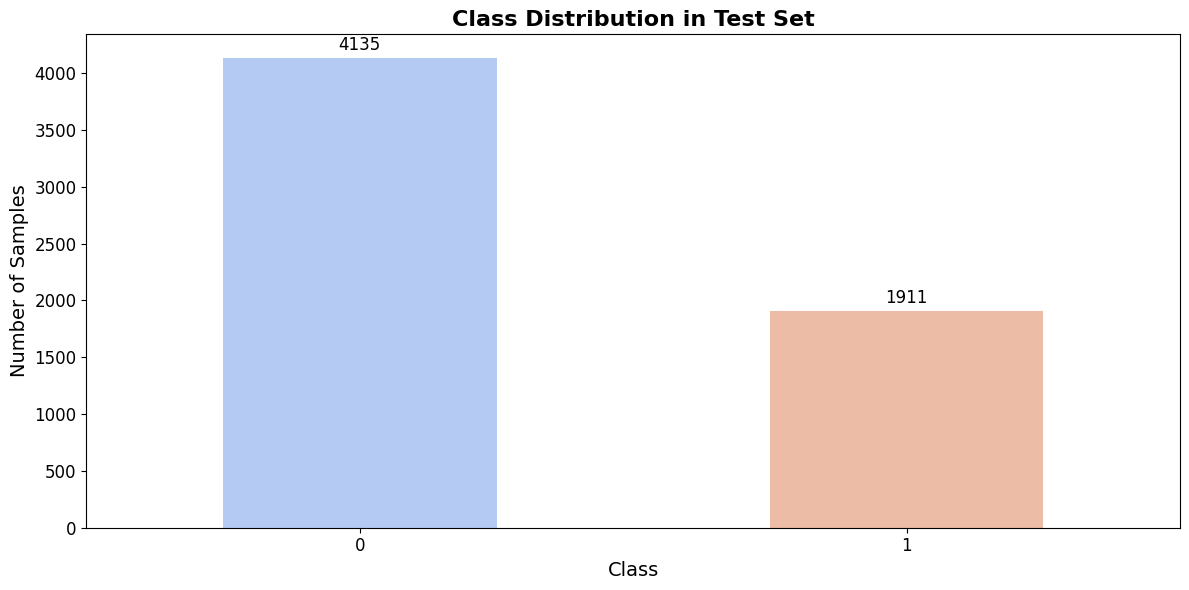

Class 0: 68.39%
Class 1: 31.61%
6046


In [8]:

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def class_balance(y_train):
    if len(y_train.shape) > 1 and y_train.shape[1] > 1:
        y_train = np.argmax(y_train, axis=1)
    class_counts = np.bincount(y_train)
    classes = np.unique(y_train)
    class_balance = dict(zip(classes, class_counts))
    
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=list(class_balance.keys()), y=list(class_balance.values()), palette="coolwarm", width=0.5)
    plt.title('Class Distribution in Test Set', fontsize=16, fontweight='bold')
    plt.xlabel('Class', fontsize=14)
    plt.ylabel('Number of Samples', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points',
                    fontsize=12)
    
    plt.tight_layout()
    plt.show()

    total_samples = len(y_train)
    for cls, count in class_balance.items():
        percentage = (count / total_samples) * 100
        print(f"Class {cls}: {percentage:.2f}%")

class_balance(y_test)
print(len(y_test))


In [17]:
def display_image_with_bbox(directory, file_list, bbox_list, target_list):
    positive_files = [file for file, target in zip(file_list, target_list) if target == 1]
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    
    for ax, selected_file in zip(axes.ravel(), positive_files):
        file_index = file_list.index(selected_file)
        
        dicom_file_path = os.path.join(directory, f"{selected_file}.dcm")
        dicom_data = pydicom.dcmread(dicom_file_path)
        image = dicom_data.pixel_array
        
        ax.imshow(image, cmap=plt.cm.bone)
        
        bbox = bbox_list[file_index]
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

    
def patient_ids(df):
    positive_rows = df[df["Target"] == 1]
    
    #file_list = positive_rows["patientId"].head(10).tolist()
    file_list = positive_rows["patientId"].sample(n = 10, random_state = 7).tolist()
    
    return file_list

file_list = patient_ids(train_labels)
print(file_list)


directory = '../input/rsna-pneumonia-detection-challenge/stage_2_train_images'
def extract_bbox_info(df, file_list):

    bbox_list = []
    
    for patient_id in file_list:
        patient_data = df[df["patientId"] == patient_id]
        bbox_info = patient_data[["x", "y", "width", "height"]].values.tolist()
        for bbox in bbox_info:
            bbox_list.append(bbox)
    
    return bbox_list

bbox_list = extract_bbox_info(train_labels, file_list)
print(bbox_list)


def extract_target_info(df, file_list):

    bbox_list = []
    
    for patient_id in file_list:
        patient_data = df[df["patientId"] == patient_id]
        bbox_info = patient_data["Target"]
        
        for bbox in bbox_info:
            bbox_list.append(bbox)
    
    return bbox_list

target_list = extract_target_info(train_labels, file_list)
print(target_list)

['d055f31c-04a0-49ea-b091-56e88b837f97', '73dec8bd-601a-4cbe-9ae8-336c5cbd77e2', '56f5bc59-c8a4-4cca-85b9-7b704532b3bd', '41ec1c4d-4c6d-41be-a305-bb43da76ac27', '242a6f0b-fc6e-42e6-84c9-f74e3d33372b', 'b2eca3cd-f9cc-46a6-b36a-2902558a7fc4', 'ab96fe46-8079-448d-a9e2-76b8e096e6ae', 'b7ac0a9c-3226-407d-9734-91a45d371732', 'fdf8ddd5-3794-4387-9051-6647f1952b36', '2f200e3f-8e4c-4675-948c-8226cd65163a']

[[274.0, 260.0, 226.0, 333.0], [555.0, 259.0, 240.0, 256.0], [564.0, 349.0, 168.0, 235.0], [578.0, 602.0, 197.0, 260.0], [102.0, 272.0, 239.0, 550.0], [140.0, 306.0, 185.0, 297.0], [290.0, 609.0, 222.0, 145.0], [689.0, 362.0, 177.0, 290.0], [281.0, 360.0, 170.0, 243.0], [270.0, 546.0, 177.0, 152.0], [660.0, 581.0, 200.0, 172.0], [653.0, 636.0, 244.0, 168.0], [210.0, 659.0, 175.0, 145.0], [619.0, 408.0, 215.0, 329.0], [199.0, 272.0, 252.0, 177.0], [269.0, 357.0, 179.0, 181.0], [639.0, 337.0, 201.0, 352.0], [143.0, 306.0, 234.0, 340.0]]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


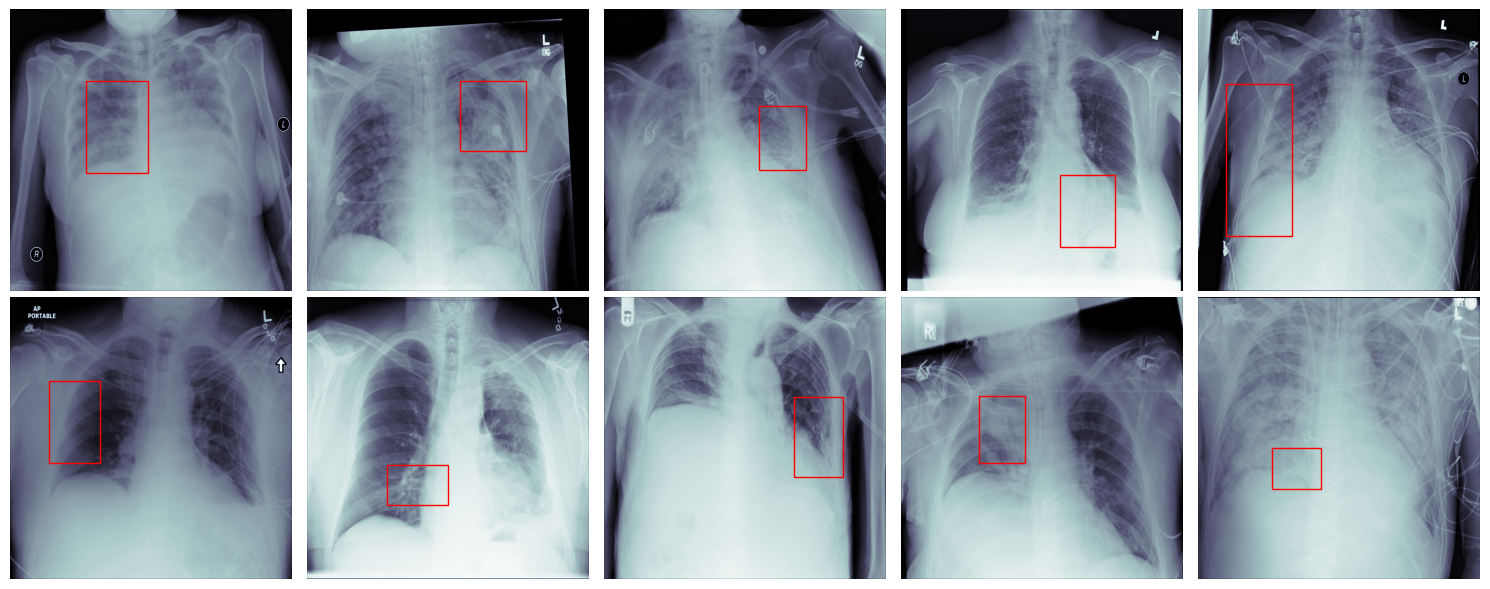

In [18]:
display_image_with_bbox(directory, file_list, bbox_list, target_list)

In [19]:
train_labels

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 activation (Activation)     (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 activation_1 (Activation)   (None, 64, 64, 128)       0         
                                                        

2023-09-09 15:54:35.317308: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1209/1209 [==============================] - 49s 31ms/step - loss: 1.9747 - accuracy: 0.5990 - val_loss: 0.6615 - val_accuracy: 0.5402 - lr: 5.0000e-04
Epoch 2/50
1209/1209 [==============================] - 35s 29ms/step - loss: 0.8573 - accuracy: 0.6313 - val_loss: 0.5791 - val_accuracy: 0.6769 - lr: 5.0000e-04
Epoch 3/50
1209/1209 [==============================] - 36s 30ms/step - loss: 0.8275 - accuracy: 0.6582 - val_loss: 0.5800 - val_accuracy: 0.7157 - lr: 5.0000e-04
Epoch 4/50
1209/1209 [==============================] - 34s 28ms/step - loss: 0.7876 - accuracy: 0.6874 - val_loss: 0.5888 - val_accuracy: 0.6880 - lr: 5.0000e-04
Epoch 5/50
1209/1209 [==============================] - 34s 28ms/step - loss: 0.7086 - accuracy: 0.7404 - val_loss: 0.5274 - val_accuracy: 0.7430 - lr: 1.0000e-04
Epoch 6/50
1209/1209 [==============================] - 34s 28ms/step - loss: 0.6918 - accuracy: 0.7472 - val_loss: 0.5281 - val_accuracy: 0.7511 - lr: 1.0000e-04
Epoch 7/50
1209/1209 [===========

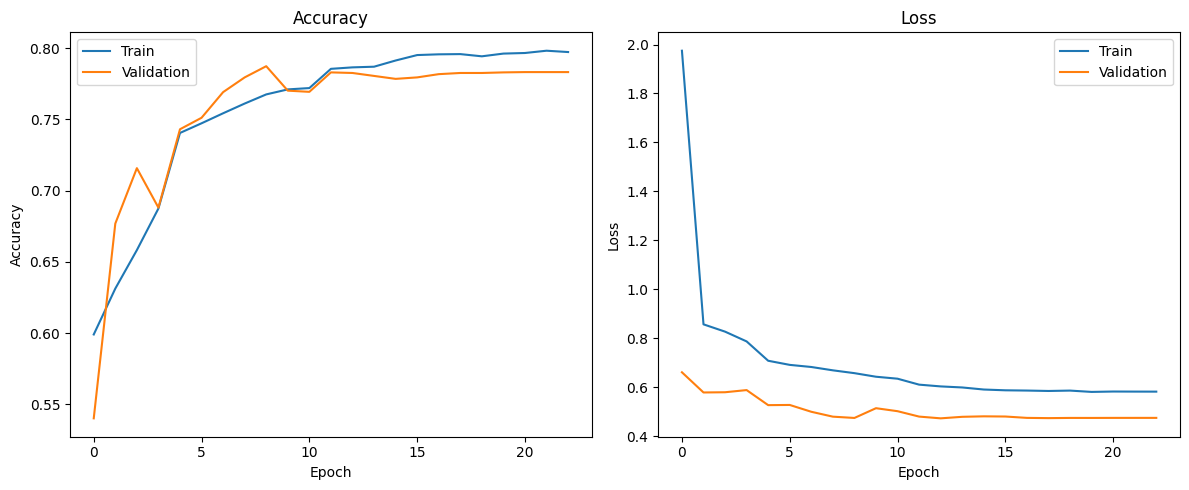

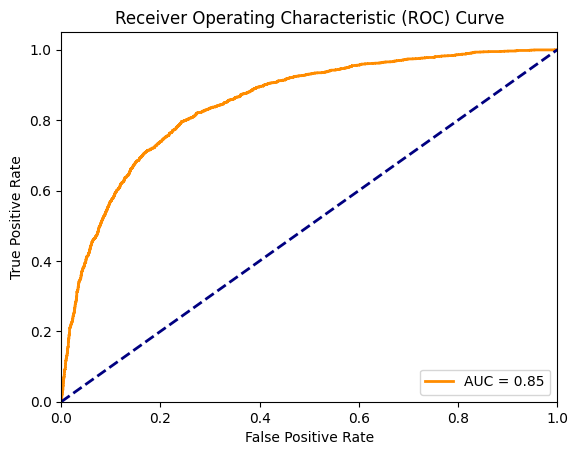

In [2]:
def build_model(input_shape, num_classes):
    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    return model


model = build_model(input_shape, num_classes)
model.compile(loss='binary_crossentropy', optimizer=AdamW(learning_rate=0.0005), metrics=['accuracy'])

model.summary()

history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_valid, y_valid),
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=10,
                      restore_best_weights=True, mode='min'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
        ],
    class_weight={0:1 , 1:2} 
)

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)


test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)


y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred))




y_pred_proba = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test[:, 1], y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

print('AUC:', roc_auc)


plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


**Transfer Learning**


94668760/94668760 [==============================] - 1s 0us/step

Epoch 1/60

1209/1209 [==============================] - 43s 25ms/step - loss: 25.9567 - accuracy: 0.6661 - val_loss: 8.7567 - val_accuracy: 0.6756 - lr: 5.0000e-04

Epoch 2/60

1209/1209 [==============================] - 27s 23ms/step - loss: 8.5003 - accuracy: 0.6787 - val_loss: 1.9305 - val_accuracy: 0.7676 - lr: 5.0000e-04

Epoch 3/60

1209/1209 [==============================] - 33s 27ms/step - loss: 3.1035 - accuracy: 0.6891 - val_loss: 0.8755 - val_accuracy: 0.7600 - lr: 5.0000e-04

Epoch 4/60

1209/1209 [==============================] - 33s 27ms/step - loss: 0.8840 - accuracy: 0.7279 - val_loss: 0.4996 - val_accuracy: 0.7560 - lr: 5.0000e-04

Epoch 5/60

1209/1209 [==============================] - 33s 27ms/step - loss: 0.6795 - accuracy: 0.7516 - val_loss: 0.6431 - val_accuracy: 0.6572 - lr: 5.0000e-04

Epoch 6/60

1209/1209 [==============================] - 33s 27ms/step - loss: 0.6812 - accuracy: 0.7532 - 

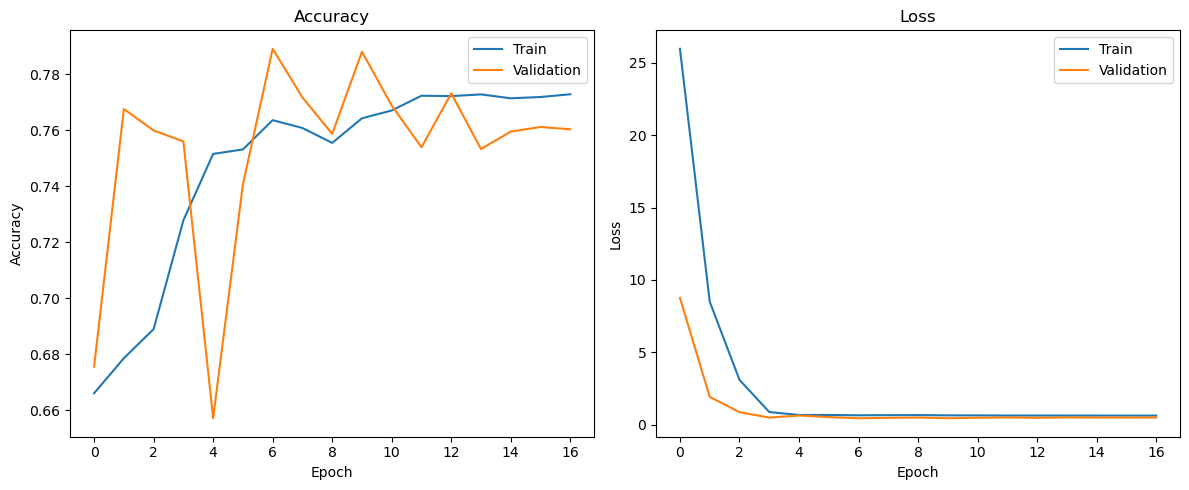

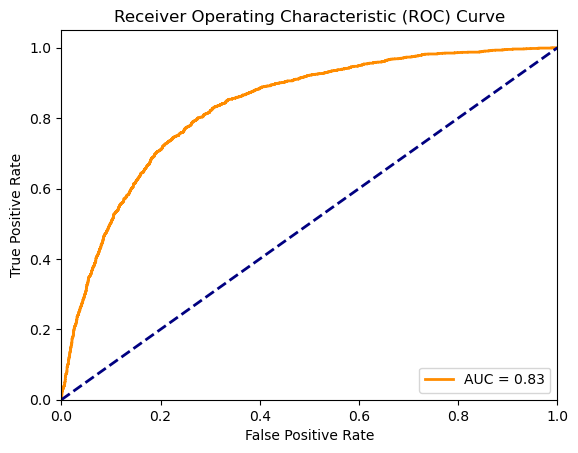

In [2]:
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False


augment = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.15, dtype='float32')
], name='AugmentationLayer')

input_shape = (128, 128, 3)  
inputs = Input(shape=input_shape, name='inputLayer')
x = augment(inputs)
pretrain_out = base_model(x, training=False)
x = Flatten()(pretrain_out)
x = Dense(64, activation='relu')(x)
x = Dense(num_classes, name='outputLayer')(x)
outputs = Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x)
model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=AdamW(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])



history = model.fit(X_train,
                    y_train,
                    batch_size=16,
                    epochs=60,
                    validation_data=(X_valid, y_valid),
                    callbacks=[
                        EarlyStopping(monitor="val_loss", patience=10,
                                      restore_best_weights=True, mode='min'),
                        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
                    ],
                    class_weight={0:1 , 1:2}  
                   )


test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)


y_pred_resnet = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred_resnet))


y_pred_proba = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test[:, 1], y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

print('AUC:', roc_auc)


plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()




17225924/17225924 [==============================] - 0s 0us/step

Epoch 1/60

1209/1209 [==============================] - 16s 11ms/step - loss: 0.7278 - accuracy: 0.7355 - val_loss: 0.6326 - val_accuracy: 0.6558 - lr: 5.0000e-04

Epoch 2/60

1209/1209 [==============================] - 13s 10ms/step - loss: 0.6785 - accuracy: 0.7553 - val_loss: 0.4681 - val_accuracy: 0.7889 - lr: 5.0000e-04

Epoch 3/60

1209/1209 [==============================] - 12s 10ms/step - loss: 0.6656 - accuracy: 0.7542 - val_loss: 0.4688 - val_accuracy: 0.7786 - lr: 5.0000e-04

Epoch 4/60

1209/1209 [==============================] - 12s 10ms/step - loss: 0.6592 - accuracy: 0.7639 - val_loss: 0.5204 - val_accuracy: 0.7666 - lr: 5.0000e-04

Epoch 5/60

1209/1209 [==============================] - 12s 10ms/step - loss: 0.6419 - accuracy: 0.7734 - val_loss: 0.5071 - val_accuracy: 0.7616 - lr: 1.0000e-04

Epoch 6/60

1209/1209 [==============================] - 12s 10ms/step - loss: 0.6341 - accuracy: 0.7708 - v

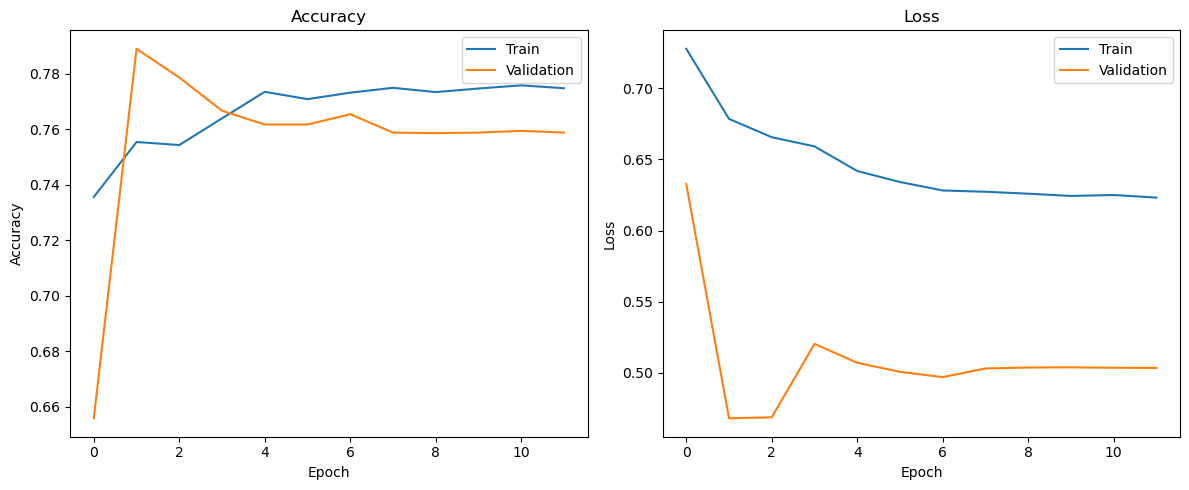

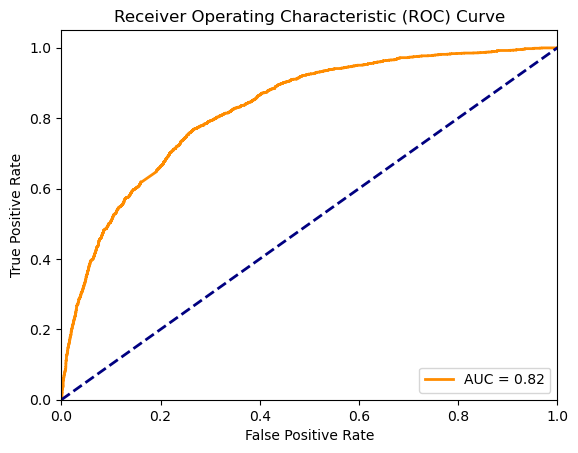

In [7]:
from tensorflow.keras.applications import MobileNet

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False


augment = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.15, dtype='float32')
], name='AugmentationLayer')

input_shape = (128, 128, 3)  
inputs = Input(shape=input_shape, name='inputLayer')
x = augment(inputs)
pretrain_out = base_model(x, training=False)
x = Flatten()(pretrain_out)
x = Dense(64, activation='relu')(x)
x = Dense(num_classes, name='outputLayer')(x)
outputs = Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x)
model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=AdamW(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])



history = model.fit(X_train,
                    y_train,
                    batch_size=16,
                    epochs=60,
                    validation_data=(X_valid, y_valid),
                    callbacks=[
                        EarlyStopping(monitor="val_loss", patience=10,
                                      restore_best_weights=True, mode='min'),
                        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
                    ],
                    class_weight={0:1 , 1:2}  
                   )


test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)


y_pred_mobilenet = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred_mobilenet))


y_pred_proba = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test[:, 1], y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

print('AUC:', roc_auc)


plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()




58889256/58889256 [==============================] - 0s 0us/step

Epoch 1/60

1209/1209 [==============================] - 38s 30ms/step - loss: 0.8121 - accuracy: 0.7386 - val_loss: 0.4594 - val_accuracy: 0.7906 - lr: 5.0000e-04

Epoch 2/60

1209/1209 [==============================] - 38s 31ms/step - loss: 0.6185 - accuracy: 0.7798 - val_loss: 0.4770 - val_accuracy: 0.7763 - lr: 5.0000e-04

Epoch 3/60

1209/1209 [==============================] - 35s 29ms/step - loss: 0.6086 - accuracy: 0.7885 - val_loss: 0.5085 - val_accuracy: 0.7556 - lr: 5.0000e-04

Epoch 4/60

1209/1209 [==============================] - 38s 32ms/step - loss: 0.5804 - accuracy: 0.7914 - val_loss: 0.4843 - val_accuracy: 0.7831 - lr: 1.0000e-04

Epoch 5/60

1209/1209 [==============================] - 38s 31ms/step - loss: 0.5738 - accuracy: 0.7955 - val_loss: 0.4949 - val_accuracy: 0.7747 - lr: 1.0000e-04

Epoch 6/60

1209/1209 [==============================] - 34s 28ms/step - loss: 0.5671 - accuracy: 0.7981 - v

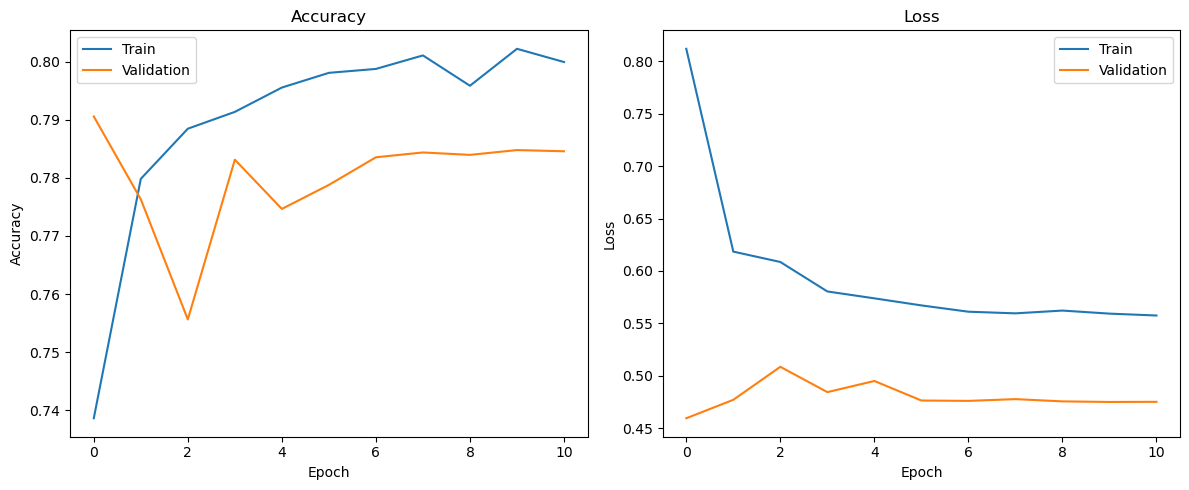

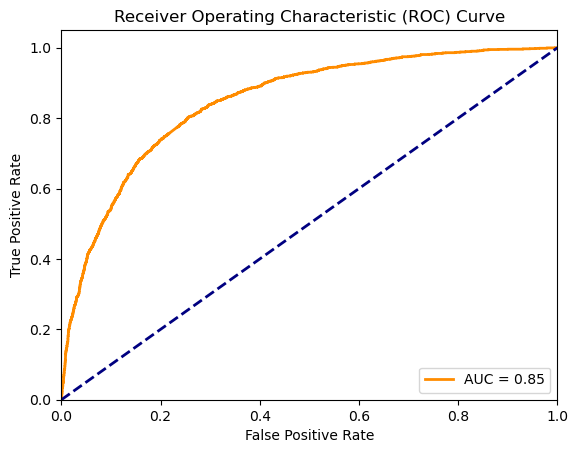

In [4]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
for layer in base_model.layers:
    layer.trainable = False

augment = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.15, dtype='float32')
], name='AugmentationLayer')

input_shape = (128, 128, 3)  
inputs = Input(shape=input_shape, name='inputLayer')
x = augment(inputs)
pretrain_out = base_model(x, training=False)
x = Flatten()(pretrain_out)
x = Dense(64, activation='relu')(x)
x = Dense(num_classes, name='outputLayer')(x)
outputs = Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x)
model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=AdamW(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(X_train,
                    y_train,
                    batch_size=16,
                    epochs=60,
                    validation_data=(X_valid, y_valid),
                    callbacks=[
                        EarlyStopping(monitor="val_loss", patience=10,
                                      restore_best_weights=True, mode='min'),
                        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
                    ],
                    class_weight={0:1 , 1:2}  
                   )


test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

y_pred_vgg = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred_vgg))

y_pred_proba = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test[:, 1], y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

print('AUC:', roc_auc)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()




87910968/87910968 [==============================] - 0s 0us/step

Epoch 1/60

1209/1209 [==============================] - 40s 27ms/step - loss: 4.9275 - accuracy: 0.6723 - val_loss: 1.1367 - val_accuracy: 0.7536 - lr: 5.0000e-04

Epoch 2/60

1209/1209 [==============================] - 26s 21ms/step - loss: 1.2403 - accuracy: 0.6969 - val_loss: 0.5170 - val_accuracy: 0.7575 - lr: 5.0000e-04

Epoch 3/60

1209/1209 [==============================] - 26s 21ms/step - loss: 0.7263 - accuracy: 0.7484 - val_loss: 0.4986 - val_accuracy: 0.7769 - lr: 5.0000e-04

Epoch 4/60

1209/1209 [==============================] - 26s 21ms/step - loss: 0.7410 - accuracy: 0.7537 - val_loss: 0.5722 - val_accuracy: 0.7802 - lr: 5.0000e-04

Epoch 5/60

1209/1209 [==============================] - 26s 21ms/step - loss: 0.7412 - accuracy: 0.7567 - val_loss: 0.5399 - val_accuracy: 0.7790 - lr: 5.0000e-04

Epoch 6/60

1209/1209 [==============================] - 26s 21ms/step - loss: 0.7110 - accuracy: 0.7605 - v

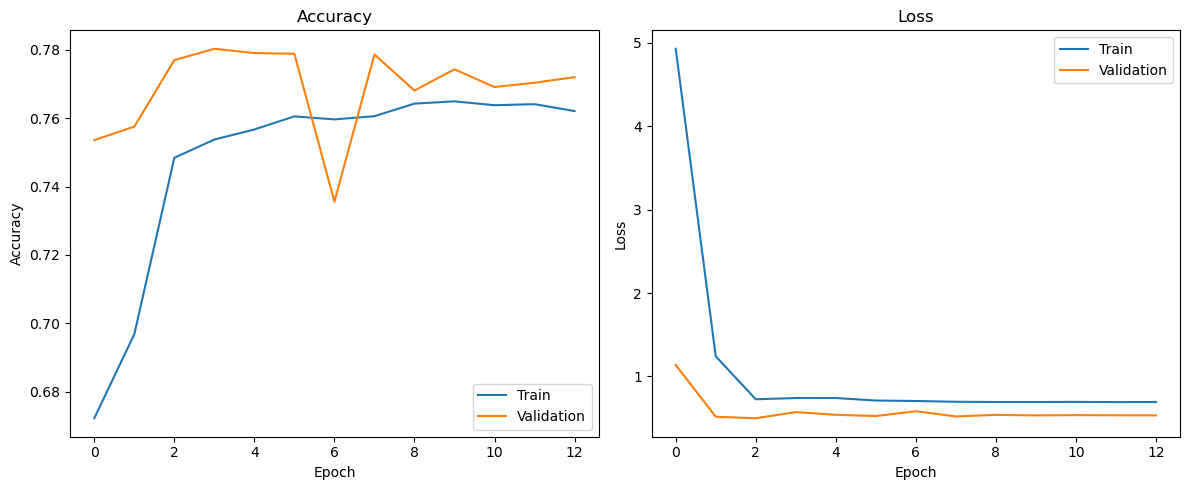

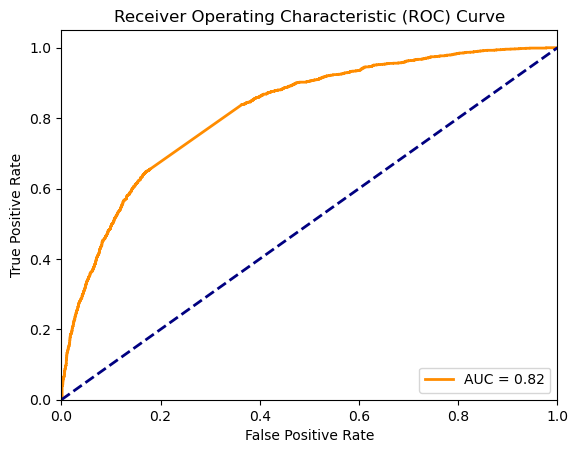

In [3]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False

augment = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.15, dtype='float32')
], name='AugmentationLayer')

inputs = Input(shape=input_shape, name='inputLayer')
x = augment(inputs)
pretrain_out = base_model(x, training=False)
x = Flatten()(pretrain_out)
x = Dense(64, activation='relu')(x)
x = Dense(num_classes, name='outputLayer')(x)
outputs = Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x)
model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=AdamW(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])



history = model.fit(X_train,
                    y_train,
                    batch_size=16,
                    epochs=60,
                    validation_data=(X_valid, y_valid),
                    callbacks=[
                        EarlyStopping(monitor="val_loss", patience=10,
                                      restore_best_weights=True, mode='min'),
                        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
                    ],
                    class_weight={0:1 , 1:2}   
                   )


test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

y_pred_inception = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred_inception))

y_pred_proba = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test[:, 1], y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

print('AUC:', roc_auc)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



29084464/29084464 [==============================] - 0s 0us/step

Epoch 1/60

1209/1209 [==============================] - 47s 32ms/step - loss: 1.2381 - accuracy: 0.6462 - val_loss: 0.6658 - val_accuracy: 0.6665 - lr: 5.0000e-04

Epoch 2/60

1209/1209 [==============================] - 35s 29ms/step - loss: 0.7785 - accuracy: 0.7506 - val_loss: 0.5570 - val_accuracy: 0.7835 - lr: 5.0000e-04

Epoch 3/60

1209/1209 [==============================] - 31s 26ms/step - loss: 0.7200 - accuracy: 0.7551 - val_loss: 0.5125 - val_accuracy: 0.7877 - lr: 5.0000e-04

Epoch 4/60

1209/1209 [==============================] - 35s 29ms/step - loss: 0.6966 - accuracy: 0.7613 - val_loss: 0.5228 - val_accuracy: 0.7654 - lr: 5.0000e-04

Epoch 5/60

1209/1209 [==============================] - 31s 26ms/step - loss: 0.6872 - accuracy: 0.7638 - val_loss: 0.6359 - val_accuracy: 0.6924 - lr: 5.0000e-04

Epoch 6/60

1209/1209 [==============================] - 31s 26ms/step - loss: 0.6666 - accuracy: 0.7673 - v

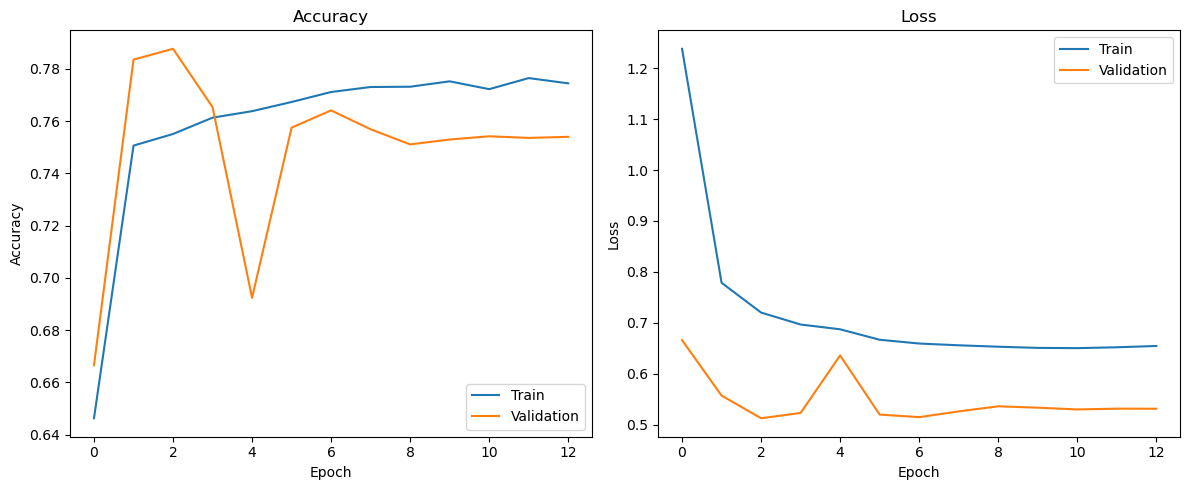

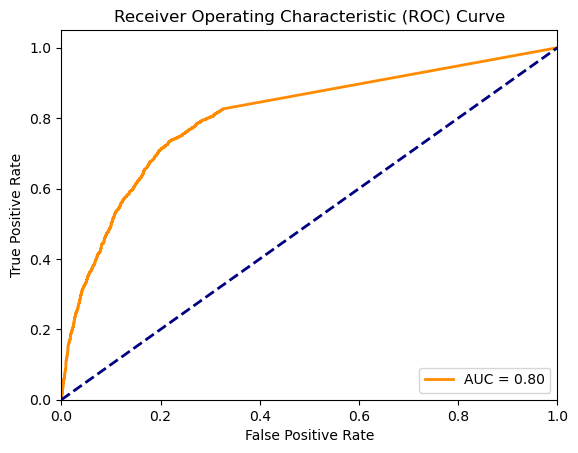

In [5]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
for layer in base_model.layers:
    layer.trainable = False
    

augment = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.15, dtype='float32')
], name='AugmentationLayer')

input_shape = (128, 128, 3)  
inputs = Input(shape=input_shape, name='inputLayer')
x = augment(inputs)
pretrain_out = base_model(x, training=False)
x = Flatten()(pretrain_out)
x = Dense(64, activation='relu')(x)
x = Dense(num_classes, name='outputLayer')(x)
outputs = Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x)
model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=AdamW(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train,
                    y_train,
                    batch_size=16,
                    epochs=60,
                    validation_data=(X_valid, y_valid),
                    callbacks=[
                        EarlyStopping(monitor="val_loss", patience=10,
                                      restore_best_weights=True, mode='min'),
                        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
                    ],
                    class_weight={0:1 , 1:2}   
                   )


test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

y_pred_densenet = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred_densenet))

y_pred_proba = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test[:, 1], y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

print('AUC:', roc_auc)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


189/189 [==============================] - 6s 30ms/step



              precision    recall  f1-score   support







           0       0.90      0.69      0.78      4135



           1       0.55      0.83      0.66      1911







    accuracy                           0.73      6046



   macro avg       0.72      0.76      0.72      6046



weighted avg       0.79      0.73      0.74      6046







189/189 [==============================] - 6s 30ms/step



AUC: 0.832340481537234


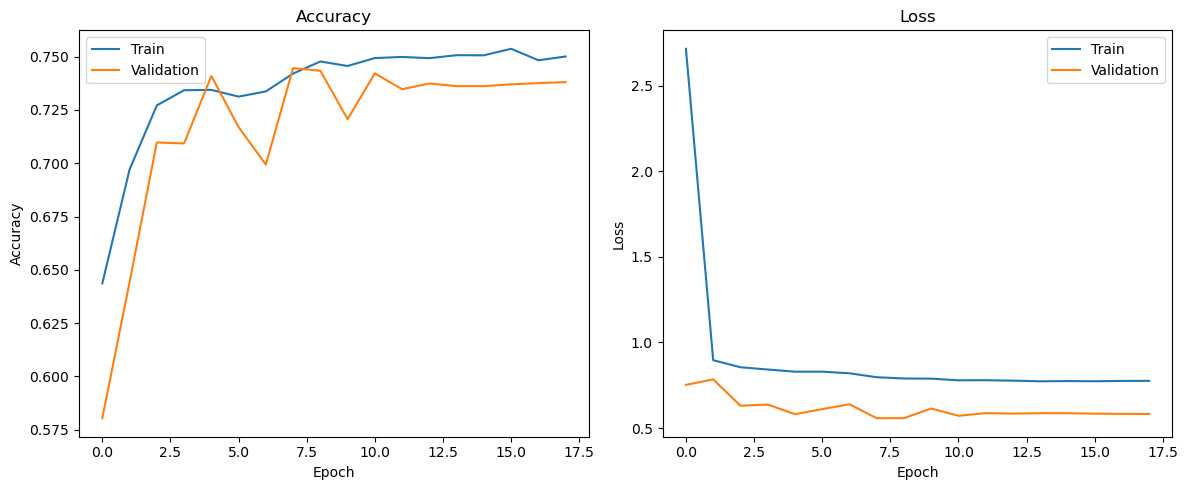

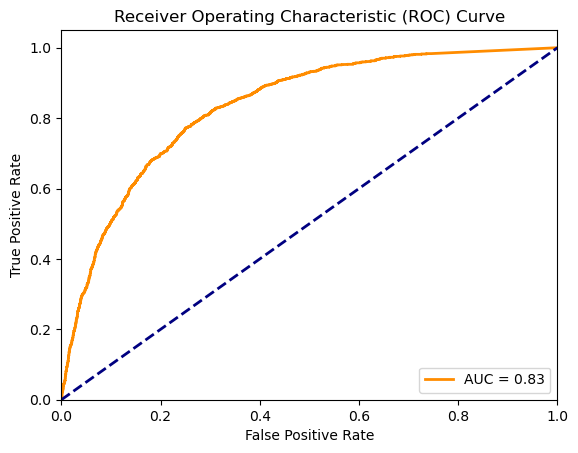

In [4]:
y_pred_densenet = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred_densenet))

# Calculate ROC curve and AUC
y_pred_proba = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test[:, 1], y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

print('AUC:', roc_auc)

# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



43941136/43941136 [==============================] - 0s 0us/step

Epoch 1/60

1209/1209 [==============================] - 49s 32ms/step - loss: 0.6809 - accuracy: 0.7564 - val_loss: 0.4993 - val_accuracy: 0.7616 - lr: 5.0000e-04

Epoch 2/60

1209/1209 [==============================] - 34s 28ms/step - loss: 0.6222 - accuracy: 0.7655 - val_loss: 0.4603 - val_accuracy: 0.7906 - lr: 5.0000e-04

Epoch 3/60

1209/1209 [==============================] - 34s 28ms/step - loss: 0.5979 - accuracy: 0.7797 - val_loss: 0.4688 - val_accuracy: 0.7813 - lr: 5.0000e-04

Epoch 4/60

1209/1209 [==============================] - 38s 31ms/step - loss: 0.5930 - accuracy: 0.7786 - val_loss: 0.4884 - val_accuracy: 0.7695 - lr: 5.0000e-04

Epoch 5/60

1209/1209 [==============================] - 34s 28ms/step - loss: 0.5684 - accuracy: 0.7909 - val_loss: 0.4424 - val_accuracy: 0.7902 - lr: 1.0000e-04

Epoch 6/60

1209/1209 [==============================] - 37s 31ms/step - loss: 0.5598 - accuracy: 0.7929 - v

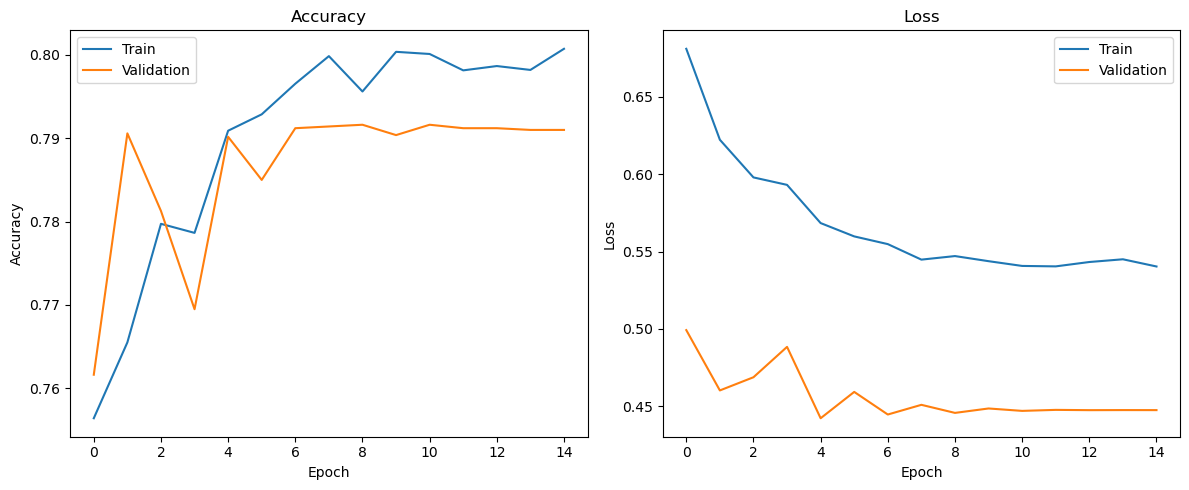

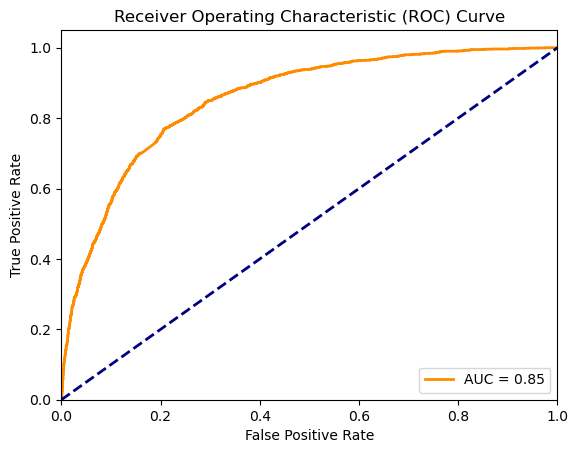

In [6]:
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
for layer in base_model.layers:
    layer.trainable = False

augment = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.15, dtype='float32')
], name='AugmentationLayer')

input_shape = (128, 128, 3)  
inputs = Input(shape=input_shape, name='inputLayer')
x = augment(inputs)
pretrain_out = base_model(x, training=False)
x = Flatten()(pretrain_out)
x = Dense(64, activation='relu')(x)
x = Dense(num_classes, name='outputLayer')(x)
outputs = Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x)
model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=AdamW(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train,
                    y_train,
                    batch_size=16,
                    epochs=60,
                    validation_data=(X_valid, y_valid),
                    callbacks=[
                        EarlyStopping(monitor="val_loss", patience=10,
                                      restore_best_weights=True, mode='min'),
                        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
                    ],
                    class_weight={0:1 , 1:2}  
                   )


test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

y_pred_efficientnet = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred_efficientnet))

y_pred_proba = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test[:, 1], y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

print('AUC:', roc_auc)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


**Ensemble Learning**

In [10]:
ensemble_predictions = (y_pred_resnet + y_pred_vgg + y_pred_densenet + y_pred_efficientnet + y_pred_inception + y_pred_mobilenet) / 6


threshold = 0.5
ensemble_class_labels = (ensemble_predictions > threshold).astype(int)

ensemble_accuracy = np.sum(ensemble_class_labels == y_true) / len(y_true)
print('Ensemble accuracy:', ensemble_accuracy)


Ensemble accuracy: 0.7874627853126034


In [11]:
ensemble_predictions = (y_pred_resnet + y_pred_vgg + y_pred_densenet + y_pred_efficientnet + y_pred_inception ) / 5

threshold = 0.5
ensemble_class_labels = (ensemble_predictions > threshold).astype(int)

ensemble_accuracy = np.sum(ensemble_class_labels == y_true) / len(y_true)
print('Ensemble accuracy:', ensemble_accuracy)


Ensemble accuracy: 0.7894475686404234


In [12]:
ensemble_predictions = (y_pred_resnet + y_pred_vgg + y_pred_efficientnet + y_pred_inception ) / 4

threshold = 0.5
ensemble_class_labels = (ensemble_predictions > threshold).astype(int)

ensemble_accuracy = np.sum(ensemble_class_labels == y_true) / len(y_true)
print('Ensemble accuracy:', ensemble_accuracy)


Ensemble accuracy: 0.7899437644723785


In [13]:
ensemble_predictions = (y_pred_resnet + y_pred_vgg + y_pred_efficientnet ) / 3

threshold = 0.5
ensemble_class_labels = (ensemble_predictions > threshold).astype(int)

ensemble_accuracy = np.sum(ensemble_class_labels == y_true) / len(y_true)
print('Ensemble accuracy:', ensemble_accuracy)


Ensemble accuracy: 0.7934171352960635


In [14]:
ensemble_predictions = ( y_pred_vgg + y_pred_efficientnet ) / 2

threshold = 0.5
ensemble_class_labels = (ensemble_predictions > threshold).astype(int)

ensemble_accuracy = np.sum(ensemble_class_labels == y_true) / len(y_true)
print('Ensemble accuracy:', ensemble_accuracy)


Ensemble accuracy: 0.7985444922262653


## Feature Extraction - RF Classifier

2023-09-01 18:11:27.201294: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355

2023-09-01 18:11:27.245057: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.

Skipping registering GPU devices...



94668760/94668760 [==============================] - 4s 0us/step


2023-09-01 18:11:35.970583: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 950796288 exceeds 10% of free system memory.


605/605 [==============================] - 165s 269ms/step


2023-09-01 18:14:21.934243: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2535456768 exceeds 10% of free system memory.


189/189 [==============================] - 51s 269ms/step


2023-09-01 18:15:15.219377: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 792461312 exceeds 10% of free system memory.


0.8392325504465763

              precision    recall  f1-score   support



           0       0.86      0.91      0.89      4135

           1       0.78      0.69      0.73      1911



    accuracy                           0.84      6046

   macro avg       0.82      0.80      0.81      6046

weighted avg       0.84      0.84      0.84      6046



AUC: 0.8877256790540604


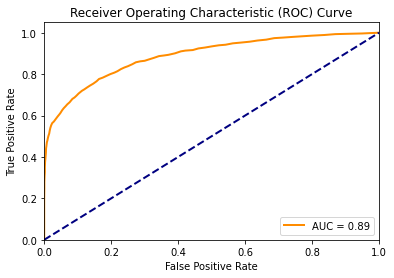

In [2]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False

augment = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.15, dtype='float32')
], name='AugmentationLayer')

input_shape = (128, 128, 3)  
inputs = Input(shape=input_shape, name='inputLayer')
x = augment(inputs)
features = base_model(x, training=False)
features = Flatten()(features)
feature_extractor = Model(inputs=inputs, outputs=features)

X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_features, np.argmax(y_train, axis=1))

y_pred_rf = clf.predict(X_test_features)
y_true = np.argmax(y_test, axis=1)

print(accuracy_score(y_true, y_pred_rf))


print(classification_report(y_true, y_pred_rf))

y_pred_proba = clf.predict_proba(X_test_features)[:, 1]
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

print('AUC:', roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


605/605 [==============================] - 7s 10ms/step



189/189 [==============================] - 2s 11ms/step



              precision    recall  f1-score   support







           0       0.85      0.93      0.89      4135



           1       0.82      0.63      0.71      1911







    accuracy                           0.84      6046



   macro avg       0.83      0.78      0.80      6046



weighted avg       0.84      0.84      0.83      6046







AUC: 0.876836073467616


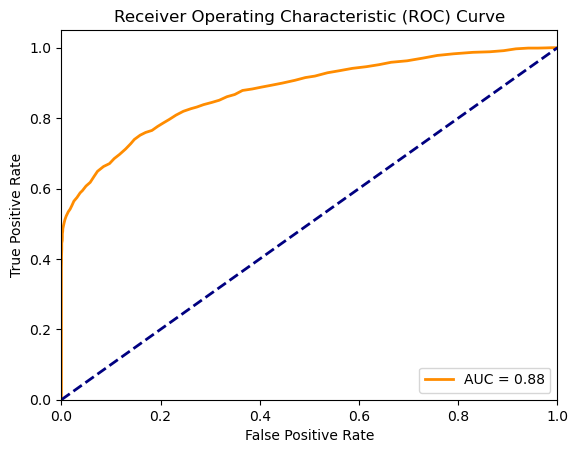

In [4]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False

augment = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.15, dtype='float32')
], name='AugmentationLayer')

input_shape = (128, 128, 3)  
inputs = Input(shape=input_shape, name='inputLayer')
x = augment(inputs)
features = base_model(x, training=False)
features = Flatten()(features)
feature_extractor = Model(inputs=inputs, outputs=features)

X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_features, np.argmax(y_train, axis=1))

y_pred_rf = clf.predict(X_test_features)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_rf))

print(accuracy_score(y_true, y_pred_rf))


y_pred_proba = clf.predict_proba(X_test_features)[:, 1]
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

print('AUC:', roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [10]:
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score

print(accuracy_score(y_true, y_pred_rf))


0.8393979490572279



58889256/58889256 [==============================] - 2s 0us/step


2023-09-01 18:17:06.225907: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 950796288 exceeds 10% of free system memory.


605/605 [==============================] - 468s 773ms/step


2023-09-01 18:24:54.672463: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 633864192 exceeds 10% of free system memory.


189/189 [==============================] - 145s 770ms/step

0.840886536553093

              precision    recall  f1-score   support



           0       0.86      0.91      0.89      4135

           1       0.78      0.69      0.73      1911



    accuracy                           0.84      6046

   macro avg       0.82      0.80      0.81      6046

weighted avg       0.84      0.84      0.84      6046



AUC: 0.891133810048994


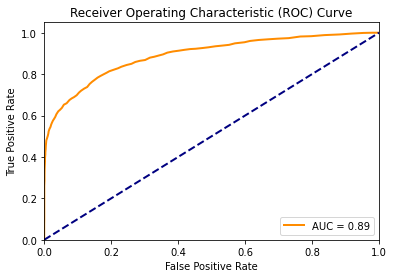

In [3]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False

augment = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.15, dtype='float32')
], name='AugmentationLayer')

input_shape = (128, 128, 3)  
inputs = Input(shape=input_shape, name='inputLayer')
x = augment(inputs)
features = base_model(x, training=False)
features = Flatten()(features)
feature_extractor = Model(inputs=inputs, outputs=features)

X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_features, np.argmax(y_train, axis=1))

y_pred_rf = clf.predict(X_test_features)
y_true = np.argmax(y_test, axis=1)

print(accuracy_score(y_true, y_pred_rf))


print(classification_report(y_true, y_pred_rf))

y_pred_proba = clf.predict_proba(X_test_features)[:, 1]
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

print('AUC:', roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



87910968/87910968 [==============================] - 3s 0us/step

605/605 [==============================] - 81s 132ms/step

189/189 [==============================] - 25s 131ms/step

0.8387363546146213

              precision    recall  f1-score   support



           0       0.87      0.90      0.88      4135

           1       0.77      0.70      0.73      1911



    accuracy                           0.84      6046

   macro avg       0.82      0.80      0.81      6046

weighted avg       0.84      0.84      0.84      6046



AUC: 0.8882035336690718


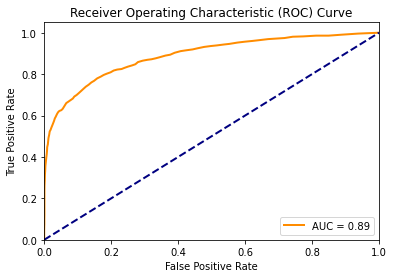

In [4]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False

augment = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.15, dtype='float32')
], name='AugmentationLayer')

input_shape = (128, 128, 3)  
inputs = Input(shape=input_shape, name='inputLayer')
x = augment(inputs)
features = base_model(x, training=False)
features = Flatten()(features)
feature_extractor = Model(inputs=inputs, outputs=features)

X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_features, np.argmax(y_train, axis=1))

y_pred_rf = clf.predict(X_test_features)
y_true = np.argmax(y_test, axis=1)

print(accuracy_score(y_true, y_pred_rf))


print(classification_report(y_true, y_pred_rf))

y_pred_proba = clf.predict_proba(X_test_features)[:, 1]
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

print('AUC:', roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



29084464/29084464 [==============================] - 1s 0us/step

605/605 [==============================] - 175s 288ms/step

189/189 [==============================] - 57s 303ms/step

0.8382401587826662

              precision    recall  f1-score   support



           0       0.86      0.91      0.88      4135

           1       0.78      0.69      0.73      1911



    accuracy                           0.84      6046

   macro avg       0.82      0.80      0.81      6046

weighted avg       0.84      0.84      0.84      6046



AUC: 0.8888531805615931


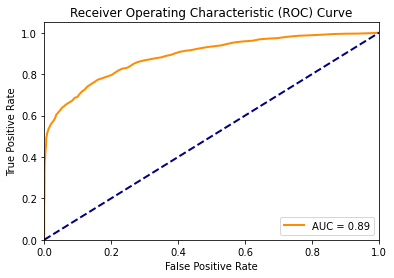

In [5]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False

augment = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.15, dtype='float32')
], name='AugmentationLayer')

input_shape = (128, 128, 3)  
inputs = Input(shape=input_shape, name='inputLayer')
x = augment(inputs)
features = base_model(x, training=False)
features = Flatten()(features)
feature_extractor = Model(inputs=inputs, outputs=features)

X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_features, np.argmax(y_train, axis=1))

y_pred_rf = clf.predict(X_test_features)
y_true = np.argmax(y_test, axis=1)

print(accuracy_score(y_true, y_pred_rf))


print(classification_report(y_true, y_pred_rf))

y_pred_proba = clf.predict_proba(X_test_features)[:, 1]
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

print('AUC:', roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


605/605 [==============================] - 174s 284ms/step

189/189 [==============================] - 53s 282ms/step

0.8412173337743963

              precision    recall  f1-score   support



           0       0.86      0.92      0.89      4135

           1       0.79      0.67      0.73      1911



    accuracy                           0.84      6046

   macro avg       0.83      0.80      0.81      6046

weighted avg       0.84      0.84      0.84      6046



AUC: 0.8880302227857937


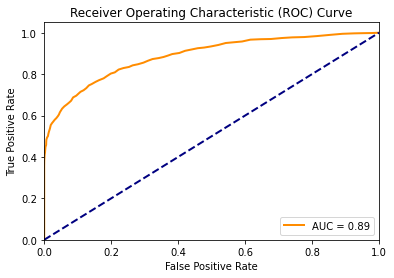

In [6]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False

augment = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.15, dtype='float32')
], name='AugmentationLayer')

input_shape = (128, 128, 3)  
inputs = Input(shape=input_shape, name='inputLayer')
x = augment(inputs)
features = base_model(x, training=False)
features = Flatten()(features)
feature_extractor = Model(inputs=inputs, outputs=features)

X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_features, np.argmax(y_train, axis=1))

y_pred_rf = clf.predict(X_test_features)
y_true = np.argmax(y_test, axis=1)

print(accuracy_score(y_true, y_pred_rf))


print(classification_report(y_true, y_pred_rf))

y_pred_proba = clf.predict_proba(X_test_features)[:, 1]
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

print('AUC:', roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


## Feature Extraction - KNN Classifier

605/605 [==============================] - 165s 272ms/step

189/189 [==============================] - 51s 268ms/step

0.7566986437313926

              precision    recall  f1-score   support



           0       0.82      0.83      0.82      4135

           1       0.62      0.60      0.61      1911



    accuracy                           0.76      6046

   macro avg       0.72      0.71      0.72      6046

weighted avg       0.75      0.76      0.76      6046



AUC: 0.7995553648861646


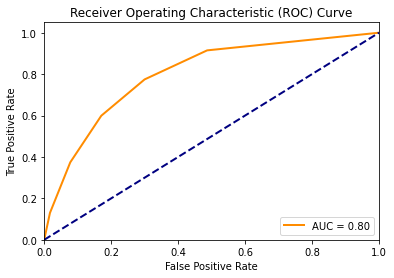

In [13]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False

augment = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.15, dtype='float32')
], name='AugmentationLayer')

input_shape = (128, 128, 3)  
inputs = Input(shape=input_shape, name='inputLayer')
x = augment(inputs)
features = base_model(x, training=False)
features = Flatten()(features)
feature_extractor = Model(inputs=inputs, outputs=features)

X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_features, np.argmax(y_train, axis=1))

y_pred_knn = knn.predict(X_test_features)
y_true = np.argmax(y_test, axis=1)

print(accuracy_score(y_true, y_pred_knn))

print(classification_report(y_true, y_pred_knn))

y_pred_proba = knn.predict_proba(X_test_features)[:, 1]
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

print('AUC:', roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


605/605 [==============================] - 13s 10ms/step



189/189 [==============================] - 2s 11ms/step



0.7563678465100894



              precision    recall  f1-score   support







           0       0.81      0.85      0.83      4135



           1       0.63      0.56      0.59      1911







    accuracy                           0.76      6046



   macro avg       0.72      0.70      0.71      6046



weighted avg       0.75      0.76      0.75      6046







AUC: 0.7842485780471615


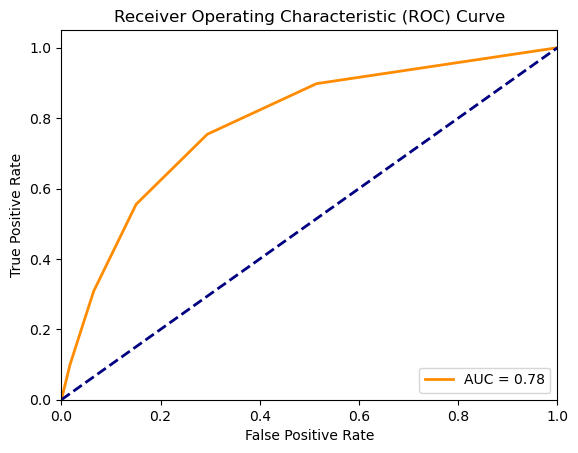

In [2]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False

augment = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.15, dtype='float32')
], name='AugmentationLayer')

input_shape = (128, 128, 3)  
inputs = Input(shape=input_shape, name='inputLayer')
x = augment(inputs)
features = base_model(x, training=False)
features = Flatten()(features)
feature_extractor = Model(inputs=inputs, outputs=features)

X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_features, np.argmax(y_train, axis=1))

y_pred_knn = knn.predict(X_test_features)
y_true = np.argmax(y_test, axis=1)

print(accuracy_score(y_true, y_pred_knn))

print(classification_report(y_true, y_pred_knn))

y_pred_proba = knn.predict_proba(X_test_features)[:, 1]
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

print('AUC:', roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


605/605 [==============================] - 469s 775ms/step

189/189 [==============================] - 147s 779ms/step

0.7707575256367847

              precision    recall  f1-score   support



           0       0.82      0.84      0.83      4135

           1       0.64      0.61      0.63      1911



    accuracy                           0.77      6046

   macro avg       0.73      0.73      0.73      6046

weighted avg       0.77      0.77      0.77      6046



AUC: 0.8122563507776843


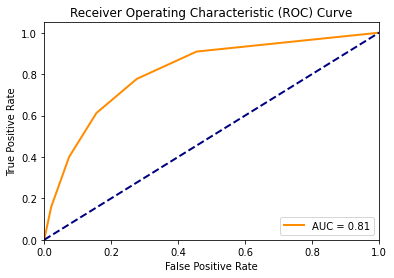

In [14]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False

augment = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.15, dtype='float32')
], name='AugmentationLayer')

input_shape = (128, 128, 3)  
inputs = Input(shape=input_shape, name='inputLayer')
x = augment(inputs)
features = base_model(x, training=False)
features = Flatten()(features)
feature_extractor = Model(inputs=inputs, outputs=features)

X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_features, np.argmax(y_train, axis=1))

y_pred_knn = knn.predict(X_test_features)
y_true = np.argmax(y_test, axis=1)

print(accuracy_score(y_true, y_pred_knn))

print(classification_report(y_true, y_pred_knn))

y_pred_proba = knn.predict_proba(X_test_features)[:, 1]
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

print('AUC:', roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


605/605 [==============================] - 80s 131ms/step

189/189 [==============================] - 25s 131ms/step

0.7758848825669864

              precision    recall  f1-score   support



           0       0.83      0.85      0.84      4135

           1       0.65      0.62      0.64      1911



    accuracy                           0.78      6046

   macro avg       0.74      0.73      0.74      6046

weighted avg       0.77      0.78      0.77      6046



AUC: 0.8159597873192623


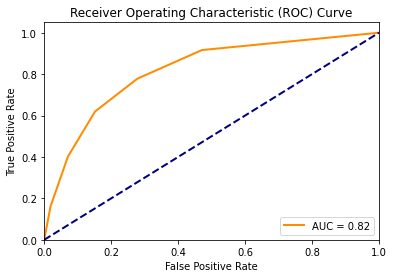

In [15]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False

augment = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.15, dtype='float32')
], name='AugmentationLayer')

input_shape = (128, 128, 3)  
inputs = Input(shape=input_shape, name='inputLayer')
x = augment(inputs)
features = base_model(x, training=False)
features = Flatten()(features)
feature_extractor = Model(inputs=inputs, outputs=features)

X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_features, np.argmax(y_train, axis=1))

y_pred_knn = knn.predict(X_test_features)
y_true = np.argmax(y_test, axis=1)

print(accuracy_score(y_true, y_pred_knn))

print(classification_report(y_true, y_pred_knn))

y_pred_proba = knn.predict_proba(X_test_features)[:, 1]
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

print('AUC:', roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


605/605 [==============================] - 186s 304ms/step

189/189 [==============================] - 57s 301ms/step

0.7509096923585842

              precision    recall  f1-score   support



           0       0.80      0.85      0.82      4135

           1       0.62      0.54      0.58      1911



    accuracy                           0.75      6046

   macro avg       0.71      0.69      0.70      6046

weighted avg       0.74      0.75      0.75      6046



AUC: 0.7878433710010839


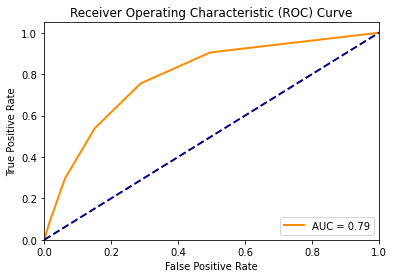

In [16]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False

augment = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.15, dtype='float32')
], name='AugmentationLayer')

input_shape = (128, 128, 3)  
inputs = Input(shape=input_shape, name='inputLayer')
x = augment(inputs)
features = base_model(x, training=False)
features = Flatten()(features)
feature_extractor = Model(inputs=inputs, outputs=features)

X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_features, np.argmax(y_train, axis=1))

y_pred_knn = knn.predict(X_test_features)
y_true = np.argmax(y_test, axis=1)

print(accuracy_score(y_true, y_pred_knn))

print(classification_report(y_true, y_pred_knn))

y_pred_proba = knn.predict_proba(X_test_features)[:, 1]
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

print('AUC:', roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


605/605 [==============================] - 175s 286ms/step

189/189 [==============================] - 53s 283ms/step

0.7704267284154813

              precision    recall  f1-score   support



           0       0.81      0.86      0.84      4135

           1       0.66      0.57      0.61      1911



    accuracy                           0.77      6046

   macro avg       0.74      0.72      0.72      6046

weighted avg       0.76      0.77      0.77      6046



AUC: 0.8105610805386242


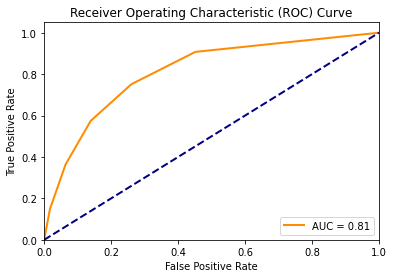

In [17]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False

augment = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.15, dtype='float32')
], name='AugmentationLayer')

input_shape = (128, 128, 3)  
inputs = Input(shape=input_shape, name='inputLayer')
x = augment(inputs)
features = base_model(x, training=False)
features = Flatten()(features)
feature_extractor = Model(inputs=inputs, outputs=features)

X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_features, np.argmax(y_train, axis=1))

y_pred_knn = knn.predict(X_test_features)
y_true = np.argmax(y_test, axis=1)

print(accuracy_score(y_true, y_pred_knn))

print(classification_report(y_true, y_pred_knn))

y_pred_proba = knn.predict_proba(X_test_features)[:, 1]
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

print('AUC:', roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


## Feature Extraction - xgboost Classifier

In [7]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable




Note: you may need to restart the kernel to use updated packages.


605/605 [==============================] - 166s 273ms/step

189/189 [==============================] - 52s 272ms/step


/user/HS224/py00128/.local/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.

  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


accuracy score:  0.8271584518690043

              precision    recall  f1-score   support



           0       0.87      0.88      0.87      4135

           1       0.74      0.71      0.72      1911



    accuracy                           0.83      6046

   macro avg       0.80      0.79      0.80      6046

weighted avg       0.83      0.83      0.83      6046



AUC: 0.8762094587625768


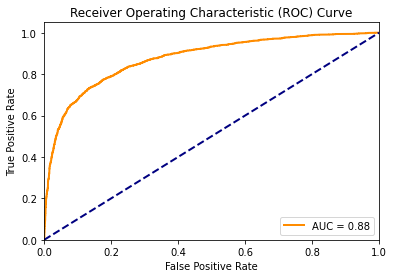

In [8]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False

augment = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.15, dtype='float32')
], name='AugmentationLayer')

input_shape = (128, 128, 3)  
inputs = Input(shape=input_shape, name='inputLayer')
x = augment(inputs)
features = base_model(x, training=False)
features = Flatten()(features)
feature_extractor = Model(inputs=inputs, outputs=features)

X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

clf = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss')
clf.fit(X_train_features, np.argmax(y_train, axis=1))

y_pred_xgb = clf.predict(X_test_features)
y_true = np.argmax(y_test, axis=1)

print("accuracy score: ", accuracy_score(y_true, y_pred_xgb))

print(classification_report(y_true, y_pred_xgb))

y_pred_proba = clf.predict_proba(X_test_features)[:, 1]
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

print('AUC:', roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()





17225924/17225924 [==============================] - 1s 0us/step


2023-08-29 21:09:52.558922: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 950796288 exceeds 10% of free system memory.


605/605 [==============================] - 39s 62ms/step


2023-08-29 21:10:32.992578: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1267728384 exceeds 10% of free system memory.


189/189 [==============================] - 12s 63ms/step


/user/HS224/py00128/.local/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.



  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


accuracy score:  0.8317896129672511



              precision    recall  f1-score   support







           0       0.86      0.90      0.88      4135



           1       0.75      0.69      0.72      1911







    accuracy                           0.83      6046



   macro avg       0.81      0.79      0.80      6046



weighted avg       0.83      0.83      0.83      6046







AUC: 0.8734095293777451


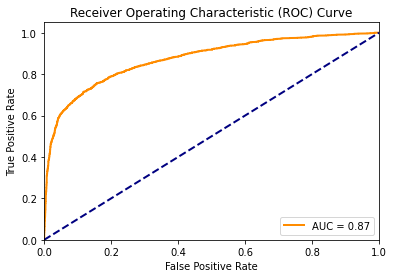

In [13]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False

augment = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.15, dtype='float32')
], name='AugmentationLayer')

input_shape = (128, 128, 3)  
inputs = Input(shape=input_shape, name='inputLayer')
x = augment(inputs)
features = base_model(x, training=False)
features = Flatten()(features)
feature_extractor = Model(inputs=inputs, outputs=features)

X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

clf = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss')
clf.fit(X_train_features, np.argmax(y_train, axis=1))

y_pred_xgb = clf.predict(X_test_features)
y_true = np.argmax(y_test, axis=1)

print("accuracy score: ", accuracy_score(y_true, y_pred_xgb))

print(classification_report(y_true, y_pred_xgb))

y_pred_proba = clf.predict_proba(X_test_features)[:, 1]
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

print('AUC:', roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


605/605 [==============================] - 480s 793ms/step

189/189 [==============================] - 139s 734ms/step


/user/HS224/py00128/.local/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.

  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


accuracy score:  0.8337743962950711

              precision    recall  f1-score   support



           0       0.88      0.88      0.88      4135

           1       0.74      0.73      0.74      1911



    accuracy                           0.83      6046

   macro avg       0.81      0.81      0.81      6046

weighted avg       0.83      0.83      0.83      6046



AUC: 0.8888847549065202


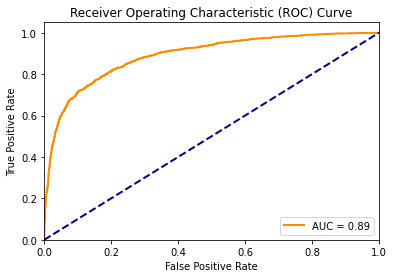

In [9]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False

augment = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.15, dtype='float32')
], name='AugmentationLayer')

input_shape = (128, 128, 3)  
inputs = Input(shape=input_shape, name='inputLayer')
x = augment(inputs)
features = base_model(x, training=False)
features = Flatten()(features)
feature_extractor = Model(inputs=inputs, outputs=features)

X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

clf = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss')
clf.fit(X_train_features, np.argmax(y_train, axis=1))

y_pred_xgb = clf.predict(X_test_features)
y_true = np.argmax(y_test, axis=1)

print("accuracy score: ", accuracy_score(y_true, y_pred_xgb))

print(classification_report(y_true, y_pred_xgb))

y_pred_proba = clf.predict_proba(X_test_features)[:, 1]
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

print('AUC:', roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


605/605 [==============================] - 78s 128ms/step

189/189 [==============================] - 25s 131ms/step


/user/HS224/py00128/.local/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.

  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


accuracy score:  0.8367515712868012

              precision    recall  f1-score   support



           0       0.87      0.89      0.88      4135

           1       0.76      0.71      0.73      1911



    accuracy                           0.84      6046

   macro avg       0.81      0.80      0.81      6046

weighted avg       0.83      0.84      0.84      6046



AUC: 0.8841027918934293


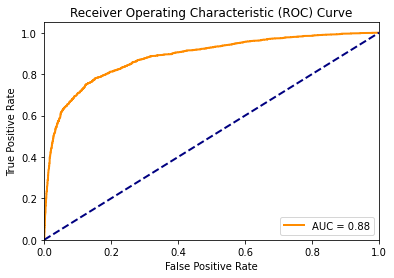

In [10]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False

augment = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.15, dtype='float32')
], name='AugmentationLayer')

input_shape = (128, 128, 3)  
inputs = Input(shape=input_shape, name='inputLayer')
x = augment(inputs)
features = base_model(x, training=False)
features = Flatten()(features)
feature_extractor = Model(inputs=inputs, outputs=features)

X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

clf = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss')
clf.fit(X_train_features, np.argmax(y_train, axis=1))

y_pred_xgb = clf.predict(X_test_features)
y_true = np.argmax(y_test, axis=1)

print("accuracy score: ", accuracy_score(y_true, y_pred_xgb))

print(classification_report(y_true, y_pred_xgb))

y_pred_proba = clf.predict_proba(X_test_features)[:, 1]
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

print('AUC:', roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


605/605 [==============================] - 187s 307ms/step

189/189 [==============================] - 58s 307ms/step


/user/HS224/py00128/.local/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.

  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


accuracy score:  0.8415481309956996

              precision    recall  f1-score   support



           0       0.88      0.89      0.89      4135

           1       0.76      0.73      0.74      1911



    accuracy                           0.84      6046

   macro avg       0.82      0.81      0.81      6046

weighted avg       0.84      0.84      0.84      6046



AUC: 0.8907048039195213


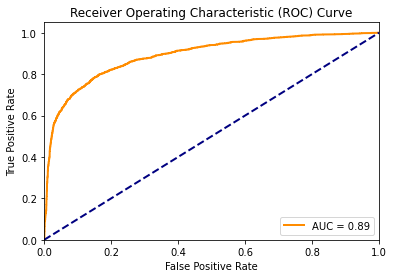

In [11]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False

augment = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.15, dtype='float32')
], name='AugmentationLayer')

input_shape = (128, 128, 3)  
inputs = Input(shape=input_shape, name='inputLayer')
x = augment(inputs)
features = base_model(x, training=False)
features = Flatten()(features)
feature_extractor = Model(inputs=inputs, outputs=features)

X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

clf = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss')
clf.fit(X_train_features, np.argmax(y_train, axis=1))

y_pred_xgb = clf.predict(X_test_features)
y_true = np.argmax(y_test, axis=1)

print("accuracy score: ", accuracy_score(y_true, y_pred_xgb))

print(classification_report(y_true, y_pred_xgb))

y_pred_proba = clf.predict_proba(X_test_features)[:, 1]
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

print('AUC:', roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


605/605 [==============================] - 175s 286ms/step

189/189 [==============================] - 54s 286ms/step


/user/HS224/py00128/.local/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.

  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


accuracy score:  0.8374131657294078

              precision    recall  f1-score   support



           0       0.87      0.89      0.88      4135

           1       0.75      0.72      0.74      1911



    accuracy                           0.84      6046

   macro avg       0.81      0.81      0.81      6046

weighted avg       0.84      0.84      0.84      6046



AUC: 0.8883977886569007


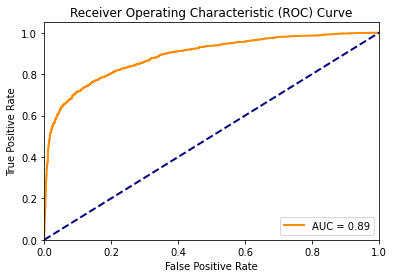

In [12]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False

augment = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.15, dtype='float32')
], name='AugmentationLayer')

input_shape = (128, 128, 3)  
inputs = Input(shape=input_shape, name='inputLayer')
x = augment(inputs)
features = base_model(x, training=False)
features = Flatten()(features)
feature_extractor = Model(inputs=inputs, outputs=features)

X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

clf = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss')
clf.fit(X_train_features, np.argmax(y_train, axis=1))

y_pred_xgb = clf.predict(X_test_features)
y_true = np.argmax(y_test, axis=1)

print("accuracy score: ", accuracy_score(y_true, y_pred_xgb))

print(classification_report(y_true, y_pred_xgb))

y_pred_proba = clf.predict_proba(X_test_features)[:, 1]
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

print('AUC:', roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


## Feature Extraction - CatBoost Classifier

In [18]:
pip install catboost

Defaulting to user installation because normal site-packages is not writeable











Note: you may need to restart the kernel to use updated packages.


605/605 [==============================] - 164s 270ms/step

189/189 [==============================] - 51s 270ms/step

0:	learn: 0.6721061	total: 730ms	remaining: 12m 9s

200:	learn: 0.3961847	total: 1m 46s	remaining: 7m 4s

400:	learn: 0.3334097	total: 3m 29s	remaining: 5m 12s

600:	learn: 0.2838814	total: 5m 14s	remaining: 3m 29s

800:	learn: 0.2459122	total: 7m	remaining: 1m 44s

999:	learn: 0.2138523	total: 8m 45s	remaining: 0us

accuracy score:  0.8221964935494542

              precision    recall  f1-score   support



           0       0.86      0.88      0.87      4135

           1       0.73      0.69      0.71      1911



    accuracy                           0.82      6046

   macro avg       0.80      0.79      0.79      6046

weighted avg       0.82      0.82      0.82      6046



AUC: 0.8749578745087468


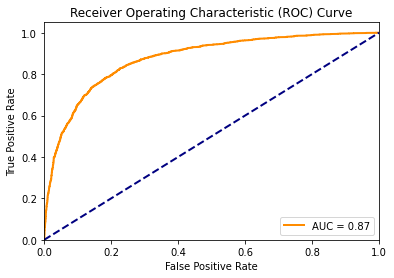

In [19]:
import numpy as np
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_curve, auc
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False

augment = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.15, dtype='float32')
], name='AugmentationLayer')

input_shape = (128, 128, 3)  
inputs = Input(shape=input_shape, name='inputLayer')
x = augment(inputs)
features = base_model(x, training=False)
features = Flatten()(features)
feature_extractor = Model(inputs=inputs, outputs=features)

X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

clf = CatBoostClassifier(iterations=1000, learning_rate=0.05, depth=6, verbose=200)
clf.fit(X_train_features, np.argmax(y_train, axis=1))

y_pred_catboost = clf.predict(X_test_features)
y_true = np.argmax(y_test, axis=1)

print("accuracy score: ", accuracy_score(y_true, y_pred_catboost))


print(classification_report(y_true, y_pred_catboost))

y_pred_proba = clf.predict_proba(X_test_features)[:, 1]
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

print('AUC:', roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


2023-08-29 21:22:09.084258: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 950796288 exceeds 10% of free system memory.


605/605 [==============================] - 40s 65ms/step


2023-08-29 21:22:49.371808: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1267728384 exceeds 10% of free system memory.


189/189 [==============================] - 13s 71ms/step



0:	learn: 0.6757167	total: 862ms	remaining: 14m 21s



200:	learn: 0.4045966	total: 2m 20s	remaining: 9m 17s



400:	learn: 0.3317342	total: 4m 22s	remaining: 6m 32s



600:	learn: 0.2780244	total: 6m 25s	remaining: 4m 15s



800:	learn: 0.2353663	total: 8m 28s	remaining: 2m 6s



999:	learn: 0.2014199	total: 10m 30s	remaining: 0us



              precision    recall  f1-score   support







           0       0.86      0.89      0.87      4135



           1       0.74      0.67      0.71      1911







    accuracy                           0.82      6046



   macro avg       0.80      0.78      0.79      6046



weighted avg       0.82      0.82      0.82      6046







AUC: 0.871409019379308


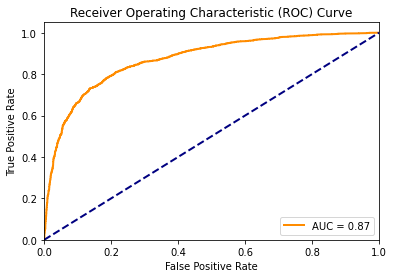

In [15]:
import numpy as np
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_curve, auc
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False

augment = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.15, dtype='float32')
], name='AugmentationLayer')

input_shape = (128, 128, 3)  
inputs = Input(shape=input_shape, name='inputLayer')
x = augment(inputs)
features = base_model(x, training=False)
features = Flatten()(features)
feature_extractor = Model(inputs=inputs, outputs=features)

X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

clf = CatBoostClassifier(iterations=1000, learning_rate=0.05, depth=6, verbose=200)
clf.fit(X_train_features, np.argmax(y_train, axis=1))

y_pred_catboost = clf.predict(X_test_features)
y_true = np.argmax(y_test, axis=1)

print("accuracy score: ", accuracy_score(y_true, y_pred_catboost))


print(classification_report(y_true, y_pred_catboost))

y_pred_proba = clf.predict_proba(X_test_features)[:, 1]
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

print('AUC:', roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [16]:
print("accuracy score: ", accuracy_score(y_true, y_pred_catboost))


accuracy score:  0.8233542838240159


605/605 [==============================] - 479s 792ms/step

189/189 [==============================] - 149s 790ms/step

0:	learn: 0.6679382	total: 426ms	remaining: 7m 5s

200:	learn: 0.3737965	total: 1m 18s	remaining: 5m 10s

400:	learn: 0.3099995	total: 2m 33s	remaining: 3m 49s

600:	learn: 0.2610755	total: 3m 49s	remaining: 2m 32s

800:	learn: 0.2242880	total: 5m 4s	remaining: 1m 15s

999:	learn: 0.1944914	total: 6m 13s	remaining: 0us

accuracy score:  0.827323850479656

              precision    recall  f1-score   support



           0       0.87      0.88      0.87      4135

           1       0.73      0.71      0.72      1911



    accuracy                           0.83      6046

   macro avg       0.80      0.80      0.80      6046

weighted avg       0.83      0.83      0.83      6046



AUC: 0.8851589822051041


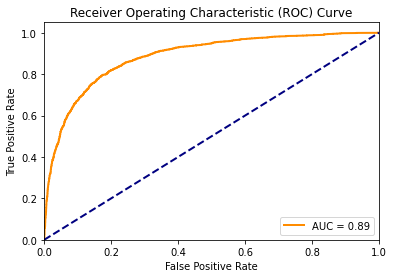

In [20]:
import numpy as np
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_curve, auc
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False

augment = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.15, dtype='float32')
], name='AugmentationLayer')

input_shape = (128, 128, 3)  
inputs = Input(shape=input_shape, name='inputLayer')
x = augment(inputs)
features = base_model(x, training=False)
features = Flatten()(features)
feature_extractor = Model(inputs=inputs, outputs=features)

X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

clf = CatBoostClassifier(iterations=1000, learning_rate=0.05, depth=6, verbose=200)
clf.fit(X_train_features, np.argmax(y_train, axis=1))

y_pred_catboost = clf.predict(X_test_features)
y_true = np.argmax(y_test, axis=1)

print("accuracy score: ", accuracy_score(y_true, y_pred_catboost))


print(classification_report(y_true, y_pred_catboost))

y_pred_proba = clf.predict_proba(X_test_features)[:, 1]
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

print('AUC:', roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


605/605 [==============================] - 78s 128ms/step

189/189 [==============================] - 25s 133ms/step

0:	learn: 0.6703853	total: 472ms	remaining: 7m 51s

200:	learn: 0.3919302	total: 1m 28s	remaining: 5m 51s

400:	learn: 0.3272892	total: 2m 54s	remaining: 4m 20s

600:	learn: 0.2771714	total: 4m 20s	remaining: 2m 52s

800:	learn: 0.2361536	total: 5m 46s	remaining: 1m 26s

999:	learn: 0.2019233	total: 7m 12s	remaining: 0us

accuracy score:  0.8274892490903076

              precision    recall  f1-score   support



           0       0.86      0.89      0.88      4135

           1       0.74      0.69      0.72      1911



    accuracy                           0.83      6046

   macro avg       0.80      0.79      0.80      6046

weighted avg       0.82      0.83      0.83      6046



AUC: 0.8776620051797112


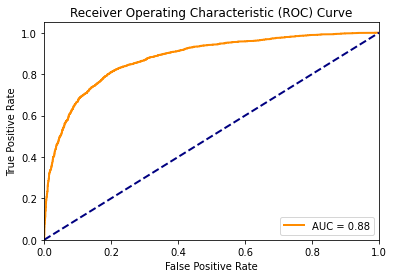

In [21]:
import numpy as np
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_curve, auc
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False

augment = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.15, dtype='float32')
], name='AugmentationLayer')

input_shape = (128, 128, 3)  
inputs = Input(shape=input_shape, name='inputLayer')
x = augment(inputs)
features = base_model(x, training=False)
features = Flatten()(features)
feature_extractor = Model(inputs=inputs, outputs=features)

X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

clf = CatBoostClassifier(iterations=1000, learning_rate=0.05, depth=6, verbose=200)
clf.fit(X_train_features, np.argmax(y_train, axis=1))

y_pred_catboost = clf.predict(X_test_features)
y_true = np.argmax(y_test, axis=1)

print("accuracy score: ", accuracy_score(y_true, y_pred_catboost))


print(classification_report(y_true, y_pred_catboost))

y_pred_proba = clf.predict_proba(X_test_features)[:, 1]
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

print('AUC:', roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


605/605 [==============================] - 188s 308ms/step

189/189 [==============================] - 58s 307ms/step

0:	learn: 0.6707157	total: 924ms	remaining: 15m 23s

200:	learn: 0.3729468	total: 2m 51s	remaining: 11m 20s

400:	learn: 0.2965197	total: 5m 38s	remaining: 8m 25s

600:	learn: 0.2418479	total: 8m 24s	remaining: 5m 34s

800:	learn: 0.2018529	total: 11m 8s	remaining: 2m 46s

999:	learn: 0.1697977	total: 13m 47s	remaining: 0us

accuracy score:  0.8341051935163745

              precision    recall  f1-score   support



           0       0.87      0.89      0.88      4135

           1       0.75      0.71      0.73      1911



    accuracy                           0.83      6046

   macro avg       0.81      0.80      0.81      6046

weighted avg       0.83      0.83      0.83      6046



AUC: 0.8882738957363245


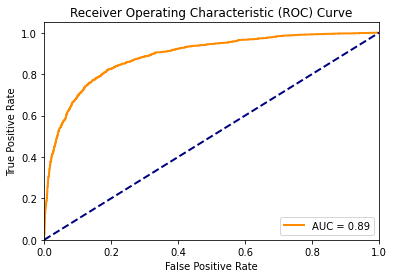

In [22]:
import numpy as np
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_curve, auc
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False

augment = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.15, dtype='float32')
], name='AugmentationLayer')

input_shape = (128, 128, 3)  
inputs = Input(shape=input_shape, name='inputLayer')
x = augment(inputs)
features = base_model(x, training=False)
features = Flatten()(features)
feature_extractor = Model(inputs=inputs, outputs=features)

X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

clf = CatBoostClassifier(iterations=1000, learning_rate=0.05, depth=6, verbose=200)
clf.fit(X_train_features, np.argmax(y_train, axis=1))

y_pred_catboost = clf.predict(X_test_features)
y_true = np.argmax(y_test, axis=1)

print("accuracy score: ", accuracy_score(y_true, y_pred_catboost))


print(classification_report(y_true, y_pred_catboost))

y_pred_proba = clf.predict_proba(X_test_features)[:, 1]
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

print('AUC:', roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


605/605 [==============================] - 173s 284ms/step

189/189 [==============================] - 53s 282ms/step

0:	learn: 0.6729320	total: 2.36s	remaining: 39m 15s

200:	learn: 0.3617554	total: 4m 45s	remaining: 18m 54s

400:	learn: 0.2746950	total: 9m 23s	remaining: 14m 1s

600:	learn: 0.2137153	total: 13m 59s	remaining: 9m 17s

800:	learn: 0.1686044	total: 18m 29s	remaining: 4m 35s

999:	learn: 0.1349181	total: 23m 4s	remaining: 0us

accuracy score:  0.8359245782335428

              precision    recall  f1-score   support



           0       0.87      0.89      0.88      4135

           1       0.75      0.72      0.73      1911



    accuracy                           0.84      6046

   macro avg       0.81      0.80      0.81      6046

weighted avg       0.83      0.84      0.83      6046



AUC: 0.8876608852079572


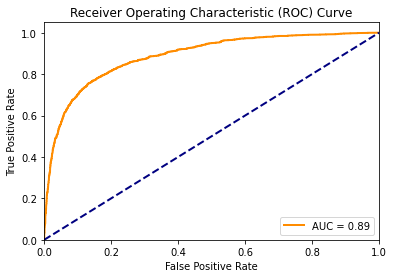

In [23]:
import numpy as np
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_curve, auc
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False

augment = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.15, dtype='float32')
], name='AugmentationLayer')

input_shape = (128, 128, 3)  # Define the input shape
inputs = Input(shape=input_shape, name='inputLayer')
x = augment(inputs)
features = base_model(x, training=False)
features = Flatten()(features)
feature_extractor = Model(inputs=inputs, outputs=features)

X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

clf = CatBoostClassifier(iterations=1000, learning_rate=0.05, depth=6, verbose=200)
clf.fit(X_train_features, np.argmax(y_train, axis=1))

y_pred_catboost = clf.predict(X_test_features)
y_true = np.argmax(y_test, axis=1)

print("accuracy score: ", accuracy_score(y_true, y_pred_catboost))


print(classification_report(y_true, y_pred_catboost))

y_pred_proba = clf.predict_proba(X_test_features)[:, 1]
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

print('AUC:', roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


2023-08-29 21:35:14.143104: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 950796288 exceeds 10% of free system memory.


605/605 [==============================] - 38s 63ms/step



189/189 [==============================] - 12s 62ms/step



0:	learn: 0.6913495	total: 738ms	remaining: 12m 17s



200:	learn: 0.5255470	total: 2m 11s	remaining: 8m 41s



400:	learn: 0.4843606	total: 4m 23s	remaining: 6m 34s



600:	learn: 0.4651591	total: 6m 32s	remaining: 4m 20s



800:	learn: 0.4520996	total: 8m 40s	remaining: 2m 9s



999:	learn: 0.4421223	total: 10m 46s	remaining: 0us



accuracy score:  0.7841548130995699



              precision    recall  f1-score   support







           0       0.81      0.89      0.85      4135



           1       0.70      0.56      0.62      1911







    accuracy                           0.78      6046



   macro avg       0.76      0.72      0.74      6046



weighted avg       0.78      0.78      0.78      6046







AUC: 0.825327180448963


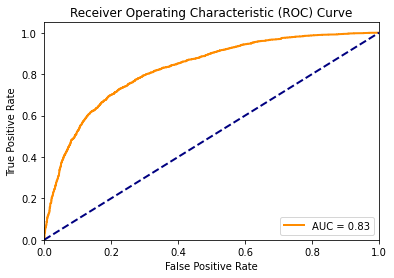

In [17]:
import numpy as np
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_curve, auc
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False

augment = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.15, dtype='float32')
], name='AugmentationLayer')

input_shape = (128, 128, 3)  
inputs = Input(shape=input_shape, name='inputLayer')
x = augment(inputs)
features = base_model(x, training=False)
features = Flatten()(features)
feature_extractor = Model(inputs=inputs, outputs=features)

X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

clf = CatBoostClassifier(iterations=1000, learning_rate=0.005, depth=6, verbose=200)
clf.fit(X_train_features, np.argmax(y_train, axis=1))

y_pred_catboost = clf.predict(X_test_features)
y_true = np.argmax(y_test, axis=1)

print("accuracy score: ", accuracy_score(y_true, y_pred_catboost))


print(classification_report(y_true, y_pred_catboost))

y_pred_proba = clf.predict_proba(X_test_features)[:, 1]
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

print('AUC:', roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


605/605 [==============================] - 39s 64ms/step



189/189 [==============================] - 12s 63ms/step



0:	learn: 0.6913495	total: 695ms	remaining: 1m 8s



99:	learn: 0.5754653	total: 1m 6s	remaining: 0us



accuracy score:  0.7629837909361561



              precision    recall  f1-score   support







           0       0.79      0.89      0.84      4135



           1       0.68      0.48      0.56      1911







    accuracy                           0.76      6046



   macro avg       0.73      0.69      0.70      6046



weighted avg       0.75      0.76      0.75      6046







AUC: 0.794165390088693


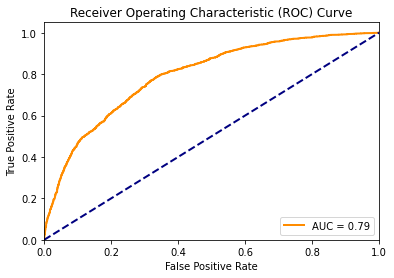

In [19]:
import numpy as np
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_curve, auc
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False

augment = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.15, dtype='float32')
], name='AugmentationLayer')

input_shape = (128, 128, 3)  
inputs = Input(shape=input_shape, name='inputLayer')
x = augment(inputs)
features = base_model(x, training=False)
features = Flatten()(features)
feature_extractor = Model(inputs=inputs, outputs=features)

X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

clf = CatBoostClassifier(iterations=100, learning_rate=0.005, depth=6, verbose=200)
clf.fit(X_train_features, np.argmax(y_train, axis=1))

y_pred_catboost = clf.predict(X_test_features)
y_true = np.argmax(y_test, axis=1)

print("accuracy score: ", accuracy_score(y_true, y_pred_catboost))


print(classification_report(y_true, y_pred_catboost))

y_pred_proba = clf.predict_proba(X_test_features)[:, 1]
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

print('AUC:', roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()





43941136/43941136 [==============================] - 2s 0us/step



605/605 [==============================] - 154s 251ms/step



189/189 [==============================] - 47s 248ms/step


/user/HS224/py00128/.local/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.



  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


accuracy score:  0.8374131657294078



              precision    recall  f1-score   support







           0       0.87      0.89      0.88      4135



           1       0.75      0.72      0.74      1911







    accuracy                           0.84      6046



   macro avg       0.81      0.81      0.81      6046



weighted avg       0.84      0.84      0.84      6046







AUC: 0.8883977886569007


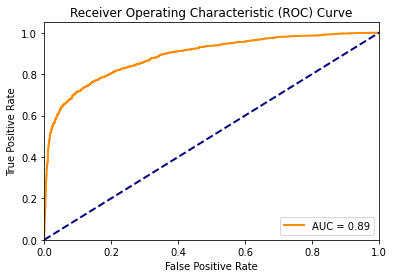

In [18]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
for layer in base_model.layers:
    layer.trainable = False

augment = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.15, dtype='float32')
], name='AugmentationLayer')

input_shape = (128, 128, 3)  
inputs = Input(shape=input_shape, name='inputLayer')
x = augment(inputs)
features = base_model(x, training=False)
features = Flatten()(features)
feature_extractor = Model(inputs=inputs, outputs=features)

X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

# Train an XGBoost classifier
clf = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss')
clf.fit(X_train_features, np.argmax(y_train, axis=1))

# Predict on the test set
y_pred_xgb = clf.predict(X_test_features)
y_true = np.argmax(y_test, axis=1)

print("accuracy score: ", accuracy_score(y_true, y_pred_xgb))

# Print classification report
print(classification_report(y_true, y_pred_xgb))

# Calculate ROC curve and AUC for the binary classification case
y_pred_proba = clf.predict_proba(X_test_features)[:, 1]
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

print('AUC:', roc_auc)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
